In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import random
import time
from datetime import date, timedelta
from pandas import DataFrame,Series

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor


from dfply import *

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
start_time = time.time()
df1 = pd.read_csv('gs://studentsmall/sep000000000000.csv')
df2 = pd.read_csv('gs://studentsmall/sep000000000001.csv')
df3 = pd.read_csv('gs://studentsmall/sep000000000002.csv')
df4 = pd.read_csv('gs://studentsmall/sep000000000003.csv')
df5 = pd.read_csv('gs://studentsmall/sep000000000004.csv')
df6 = pd.read_csv('gs://studentsmall/sep000000000005.csv')
print("--- %s seconds ---" % (time.time() - start_time))

--- 222.92219066619873 seconds ---


In [3]:
start_time = time.time()
df = pd.DataFrame(np.concatenate([df1.values, df2.values, df3.values, df4.values, df5.values ,df6.values]), columns=df1.columns)
print("--- %s seconds ---" % (time.time() - start_time))

--- 88.40058755874634 seconds ---


In [4]:
len(df)

9505220

In [5]:
total_users = df['userID'].nunique()
total_users

17000

In [6]:
data = df.copy()

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9505220 entries, 0 to 9505219
Data columns (total 87 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   eventID                   object
 1   userID                    object
 2   sessionID                 object
 3   eventTimestamp            object
 4   eventName                 object
 5   eventLevel                object
 6   gaUserStartDate           object
 7   gaUserAcquisitionChannel  object
 8   msSinceLastEvent          object
 9   acquisitionChannel        object
 10  action                    object
 11  awardType                 object
 12  build                     object
 13  coinBalance               object
 14  collectInsertedTimestamp  object
 15  deviceName                object
 16  firstRun                  object
 17  isTutorial                object
 18  mainEventID               object
 19  missionID                 object
 20  missionName               object
 21  platform

In [8]:
# caculate userAge, which is how many days the event happened since gaUserStartDate
start_time = time.time()
data['eventTimestamp'] = pd.to_datetime(data['eventTimestamp'])
data['gaUserStartDate'] = pd.to_datetime(data['gaUserStartDate'])
data['userAge'] = (data['eventTimestamp'] - data['gaUserStartDate']).dt.days
print("--- %s seconds ---" % (time.time() - start_time))

--- 1504.599939584732 seconds ---


In [9]:
userID_uni = data['userID'].unique()
userID_uni = pd.DataFrame(userID_uni, columns = ['userID'])


In [10]:
start_time = time.time()
total_result = {}
day_cases = [3, 7, 20, 30]

for day_case in day_cases:
    day = data[(data['userAge'] <= day_case) & (data['gaUserStartDate'] >= min(data['eventTimestamp']))]
    print(len(day), day_case)

    # countAdImpression: select 'adImpression' from eventName, and then count rows grouping by userID
    impression_day = day[day['eventName'] == 'adImpression'][['userID', 'eventName','action']]
    userID_impression_day = impression_day.groupby('userID').size()
    userID_impression_day = pd.DataFrame(userID_impression_day,columns = ['countAdImpression'])

    # countAdClicked: select 'adImpression' from eventName and 'clicked' from action, then count rows grouping by userID
    impression_click_day = day[(day['eventName'] == 'adImpression') & (day['action'] == 'clicked')][['userID', 'eventName','action']]
    userID_impression_click_day = impression_click_day.groupby('userID').size()
    userID_impression_click_day = pd.DataFrame(userID_impression_click_day,columns = ['countAdClicked'])

    # missionTime: select 'missionCompleted' from eventName, then sum time
    missionTime_raw_day = day[(day['eventName'] == 'missionCompleted')][['userID', 'time']]
    missionTime_day = missionTime_raw_day.groupby('userID').sum()
    missionTime_day = missionTime_day.rename(columns = {'time': 'missionTime'})

    # CountMission = select 'missionCompleted'from eventName, then count rows
    missionCount_day = missionTime_raw_day.groupby('userID').size()
    missionCount_day = pd.DataFrame(missionCount_day, columns=['CountMission'])
    
    # timePerMission
    userID_timePerMission_day = pd.merge(missionTime_day,missionCount_day, on='userID')
    userID_timePerMission_day['timePerMission']= userID_timePerMission_day['missionTime']/userID_timePerMission_day['CountMission']
    
    # dailyMissionTime = select "dailyMissionCompleted" from eventName, then sum time
    dailyMissionTime_raw_day = day[(day['eventName'] == 'dailyMissionCompleted')][['userID', 'time']]
    dailyMissionTime_day = dailyMissionTime_raw_day.groupby('userID').sum()
    dailyMissionTime_day = dailyMissionTime_day.rename(columns = {'time': 'dailyMissionTime'})
    
    # CountDailyMission = select "dailyMissionCompleted" from eventName, then count rows
    dailyMissionCount_day = dailyMissionTime_raw_day.groupby('userID').size()
    dailyMissionCount_day = pd.DataFrame(dailyMissionCount_day, columns=['CountDailyMission'])
    
    # timePerDailyMission
    timePerDailyMission_day = pd.merge(dailyMissionTime_day,dailyMissionCount_day, on='userID')
    timePerDailyMission_day['timePerDailyMission']= dailyMissionTime_day['dailyMissionTime']/dailyMissionCount_day['CountDailyMission']
     
    # totalHintsUsed: select 'missionCompleted' or 'dailyMissionCompleted' from eventName, then sum hintUsed
    hint_day = day[(day['eventName'] == 'missionCompleted')][['userID', 'hintsUsed']]
    totalHint_day = hint_day.groupby('userID').sum()

    # hintPerMission: totalHintsUsed/CountMission
    hintPerMission_day = pd.merge(totalHint_day,missionCount_day, on='userID')
    hintPerMission_day['hintsPerMission'] = hintPerMission_day['hintsUsed']/hintPerMission_day['CountMission']
    hintPerMission_day = hintPerMission_day.drop(columns = ['CountMission'])
    
    # Level reached at end of the day case
    level_day = day.groupby(['userID'])['userLevel'].max()
    level_day = pd.DataFrame(level_day, columns = ['userLevel'])
    
    # hintPerLevel
    hintPerLevel_day = pd.merge(totalHint_day,level_day, on='userID')
    hintPerLevel_day['hintsPerLevel'] = hintPerLevel_day['hintsUsed']/hintPerLevel_day['userLevel']
    hintPerLevel_day = hintPerLevel_day.drop(columns = ['hintsUsed'])
    
    # countSpecialOffer: select 'specialOffer' from eventName, then count rows
    speOffer_day = day[(day['eventName'] == 'specialOffer')]
    speoffer_count_day = speOffer_day.groupby('userID').size()
    speoffer_count_day = pd.DataFrame(speoffer_count_day,columns = ['countSpeOffer'])

    # countSpecialOfferAccept: select 'specialOffer' from eventName and 'accepted' from action, and then count rows 
    SpeOffer_accept_day = day[(day['eventName'] == 'specialOffer') & (day['action'] == 'accepted')]
    SpeOffer_accept_day = SpeOffer_accept_day.groupby('userID').size()
    SpeOffer_accept_day = pd.DataFrame(SpeOffer_accept_day,columns = ['countSpeOfferAccept'])
    
    # totalDuplicateWords: select 'missionCompleted' or 'dailyMissionCompleted' from eventName, and then sum duplicateWords
    # grouping by userID
    DuplicateWords_raw = day[day['eventName'] == 'missionCompleted'][['userID','duplicateWords']]
    DuplicateWords = DuplicateWords_raw.groupby('userID').sum()

    # duplicateWordsPerMis: duplicateWords/CountMission
    DuplicateWordsPerMis = pd.merge(DuplicateWords,missionCount_day, on='userID')
    DuplicateWordsPerMis['duplicateWordsPerMis'] = DuplicateWordsPerMis['duplicateWords']/DuplicateWordsPerMis['CountMission']
    DuplicateWordsPerMis = DuplicateWordsPerMis.drop(columns = ['CountMission'])
    
    # totalExtraWords: select 'missionCompleted' from eventName, and then sum extraWords
    # grouping by userID
    ExtraWords_raw = day[day['eventName'] == 'missionCompleted'][['userID','extraWords']]
    ExtraWords = ExtraWords_raw.groupby('userID').sum()

    # extraWordsPerMis: totalExtraWords/CountMission
    extraWordsPerMis = pd.merge(ExtraWords,missionCount_day, on='userID')
    extraWordsPerMis['extraWordsPerMis'] = extraWordsPerMis['extraWords']/extraWordsPerMis['CountMission']
    extraWordsPerMis = extraWordsPerMis.drop(columns = ['CountMission'])
    
    # totalInvalidWords: select 'missionCompleted' from eventName, and then sum invalidWords
    InvalidWords_raw = day[day['eventName'] == 'missionCompleted'][['userID','invalidWords']]
    InvalidWords = InvalidWords_raw.groupby('userID').sum()

    # invalidWordsPerMis
    InvalidWordsPerMis = pd.merge(InvalidWords,missionCount_day, on='userID')
    InvalidWordsPerMis['invalidWordsPerMis'] = InvalidWordsPerMis['invalidWords']/InvalidWordsPerMis['CountMission']
    InvalidWordsPerMis = InvalidWordsPerMis.drop(columns = ['CountMission'])
    
    # playerIQ: select 'missionCompleted' or 'dailyMissionCompleted' from eventName, and then sum playerIQ
    # grouping by userID
    playerIQ_raw = day[(day['eventName'] == 'missionCompleted')|(day['eventName'] == 'dailyMissionCompleted')][['userID','playerIQ']]
    playerIQ = playerIQ_raw.groupby('userID').sum()

    
    # push: select out "gameStarted" from eventName, find the push status when eventTimestamp = max(eventTimestamp) 
    # grouping by each user
    push_raw = day[day['eventName'] == 'gameStarted'][['userID','push','eventTimestamp']]
    push = push_raw.loc[push_raw.groupby("userID")["eventTimestamp"].idxmax()]
    push = push.drop(columns = ['eventTimestamp']).set_index('userID') 
    
    # total shuffles: select missionCompleted and sum shuffles
    # shuffle per mission: total shuffles/CountMission
    totalShuffles = day[(day['eventName']=='missionCompleted')].groupby(['userID']).agg({'missionName':'nunique','shuffles':'sum'})
    totalShuffles['shufflesPerMission']=totalShuffles['shuffles'].div(totalShuffles['missionName'])
    shuffles = totalShuffles.drop(columns = ['missionName'])
    
    
    # building userprofile through acquisitionchannel,platform,
    user_profile=(day >> select('userID','gaUserAcquisitionChannel','platform') >> group_by('userID')).drop_duplicates()
    user_profile = user_profile[user_profile.gaUserAcquisitionChannel != "None"]
    user_profile = user_profile.drop_duplicates(subset='userID', keep="first").set_index('userID')
    
    # user removedAds 
    user_removedAds_raw = day[day['eventName'] == 'gameStarted'][['userID','removedAds','eventTimestamp']]
    user_removedAds = user_removedAds_raw.loc[user_removedAds_raw.groupby("userID")["eventTimestamp"].idxmax()]
    user_removedAds = user_removedAds.drop(columns = ['eventTimestamp']).set_index('userID') 
    
    # countVideoOffer: select 'videoOffer' from eventName and corresponding action, then count rows
    vidOffer_cvv = day[(day['eventName'] == 'videoOffer') & (day['action'] == 'CVV')]
    vidOffer_cvv_count = vidOffer_cvv.groupby('userID').size()
    vidOffer_cvv_count = pd.DataFrame(vidOffer_cvv_count, columns = ['countCVV'])
    
    vidOffer_no = day[(day['eventName'] == 'videoOffer') & (day['action'] == 'NO')]
    vidOffer_no_count = vidOffer_no.groupby('userID').size()
    vidOffer_no_count = pd.DataFrame(vidOffer_no_count, columns = ['countNO'])
    
    vidOffer_noCmplt = day[(day['eventName'] == 'videoOffer') & (day['action'] == 'NOTCOMPLETED')]
    vidOffer_noCmplt_count = vidOffer_noCmplt.groupby('userID').size()
    vidOffer_noCmplt_count = pd.DataFrame(vidOffer_noCmplt_count, columns = ['countNoCmplt'])
    
    # lifespan
    user_lifespan=(day >> select('userID','userAge') >> group_by('userID') >> summarize(Lifespan=X.userAge.max()))
    
    # adRevenue for ad impressions and video offers
    total_adRevenue = (day >> select('userID','almaxRevenue') >> group_by('userID') >> summarize(ad_Rev=X.almaxRevenue.sum()))
    adImpression_revenue = (day >> select('userID','almaxRevenue', 'almaxAdUnitType') >>  mask(X.almaxAdUnitType == 'BANNER') >> group_by('userID') >> summarize(adImpression_Rev=X.almaxRevenue.sum()))
    videoOffer_revenue = (day >> select('userID','almaxRevenue', 'almaxAdUnitType') >>  mask((X.almaxAdUnitType == 'INTER') |  (X.almaxAdUnitType == 'REWARD')) >> group_by('userID') >> summarize(videoOffer_Rev=X.almaxRevenue.sum()))

    # merge into one dataframe
    agg_data = pd.merge(userID_uni,userID_impression_day,on='userID', how='left')
    agg_data = pd.merge(agg_data, userID_impression_click_day, on='userID', how='left')
    agg_data = pd.merge(agg_data, userID_timePerMission_day, on='userID', how='left')
    agg_data = pd.merge(agg_data, timePerDailyMission_day, on='userID', how= 'left')
    agg_data = pd.merge(agg_data, hintPerMission_day, on='userID', how='left')
    agg_data = pd.merge(agg_data, hintPerLevel_day, on= 'userID', how='left')
    agg_data = pd.merge(agg_data, speoffer_count_day, on='userID', how='left')
    agg_data = pd.merge(agg_data, SpeOffer_accept_day, on='userID', how='left')
    agg_data = pd.merge(agg_data, DuplicateWordsPerMis, on='userID', how='left')
    agg_data = pd.merge(agg_data, extraWordsPerMis, on='userID', how='left')
    agg_data = pd.merge(agg_data, InvalidWordsPerMis, on='userID', how='left')
    agg_data = pd.merge(agg_data, playerIQ, on='userID', how='left')
    agg_data = pd.merge(agg_data, push, on='userID', how='left')
    agg_data = pd.merge(agg_data, shuffles, on='userID', how='left')
    agg_data = pd.merge(agg_data, user_profile, on='userID', how='left')
    agg_data = pd.merge(agg_data, user_removedAds, on='userID', how='left')
    agg_data = pd.merge(agg_data, vidOffer_cvv_count, on='userID', how='left')
    agg_data = pd.merge(agg_data, vidOffer_no_count, on='userID', how='left')
    agg_data = pd.merge(agg_data, vidOffer_noCmplt_count, on='userID', how='left')
    agg_data = pd.merge(agg_data, user_lifespan, on='userID', how='left')
    agg_data = pd.merge(agg_data, total_adRevenue, on='userID', how='left')
    agg_data = pd.merge(agg_data, adImpression_revenue, on='userID', how='left')
    agg_data = pd.merge(agg_data, videoOffer_revenue, on='userID', how='left')
    
    total_result[day_case] = agg_data
print("--- %s seconds ---" % (time.time() - start_time))

4444522 3
6259794 7
8967355 20
9505220 30
--- 877.0015435218811 seconds ---


In [12]:
total_result[3].head()
## most of nulls could be filled with 0

userID  countAdImpression  countAdClicked  \
0  9f951230-bf3e-408e-acfe-c91273015dd7               59.0             4.0   
1  1FF0ECB5-5B5F-4677-BB9C-2CFE8039C4AA                1.0             NaN   
2  5512235B-8679-4A37-855F-F9772649E4CD                6.0             NaN   
3  e47f1e66-da48-4da8-8a7b-400ffdba55f7               34.0             NaN   
4  622aa638-44bd-4c7a-88d0-4ccfda8e6f4c                7.0             1.0   

   missionTime  CountMission  timePerMission  dailyMissionTime  \
0      14652.0          87.0      168.413793               NaN   
1      29765.0         830.0       35.861446              90.0   
2        840.0          19.0       44.210526             379.0   
3      16399.0          50.0      327.980000             600.0   
4       2536.0          23.0      110.260870             299.0   

   CountDailyMission  timePerDailyMission  hintsUsed  ...  \
0                NaN                  NaN       12.0  ...   
1                2.0                 45.0       57.0  ...   
2                2.0                189.5        1.0  ...   
3                1.0                600.0        6.0  ...   
4                1.0                299.0        7.0  ...   

                    gaUserAcquisitionChannel  platform  removedAds  countCVV  \
0                 android af_cross_promotion   ANDROID         NaN       NaN   
1                              ios peoplefun       IOS           1       NaN   
2                              ios peoplefun       IOS         NaN       NaN   
3  UAC_Display googleadwords_int teamincipia   ANDROID         NaN       NaN   
4                 android af_cross_promotion   ANDROID         NaN       NaN   

   countNO  countNoCmplt  Lifespan    ad_Rev  adImpression_Rev  videoOffer_Rev  
0      5.0           NaN       3.0  0.704107          0.175453        0.528654  
1      NaN           NaN       3.0  0.000000               NaN             NaN  
2      NaN           NaN       3.0  0.000000               NaN             NaN  
3      4.0           NaN       3.0  1.152750          0.546410        0.606340  
4      NaN           NaN       3.0  0.033050          0.018020        0.015030  

[5 rows x 35 columns]

In [13]:
# the final dataframe for data from day0 to day3 after dropping rows with NaN in all columns
var = total_result[3]
var.set_index('userID', inplace = True)
var.dropna(axis=0, how='all', thresh=None, subset=None, inplace=True)

In [14]:
var = var.dropna(subset = ['gaUserAcquisitionChannel', 'platform'])
var.fillna(0 , inplace = True)
var.head(2)

countAdImpression  countAdClicked  \
userID                                                                    
9f951230-bf3e-408e-acfe-c91273015dd7               59.0             4.0   
1FF0ECB5-5B5F-4677-BB9C-2CFE8039C4AA                1.0             0.0   

                                      missionTime  CountMission  \
userID                                                            
9f951230-bf3e-408e-acfe-c91273015dd7      14652.0          87.0   
1FF0ECB5-5B5F-4677-BB9C-2CFE8039C4AA      29765.0         830.0   

                                      timePerMission  dailyMissionTime  \
userID                                                                   
9f951230-bf3e-408e-acfe-c91273015dd7      168.413793               0.0   
1FF0ECB5-5B5F-4677-BB9C-2CFE8039C4AA       35.861446              90.0   

                                      CountDailyMission  timePerDailyMission  \
userID                                                                         
9f951230-bf3e-408e-acfe-c91273015dd7                0.0                  0.0   
1FF0ECB5-5B5F-4677-BB9C-2CFE8039C4AA                2.0                 45.0   

                                      hintsUsed  hintsPerMission  ...  \
userID                                                            ...   
9f951230-bf3e-408e-acfe-c91273015dd7       12.0         0.137931  ...   
1FF0ECB5-5B5F-4677-BB9C-2CFE8039C4AA       57.0         0.068675  ...   

                                        gaUserAcquisitionChannel  platform  \
userID                                                                       
9f951230-bf3e-408e-acfe-c91273015dd7  android af_cross_promotion   ANDROID   
1FF0ECB5-5B5F-4677-BB9C-2CFE8039C4AA               ios peoplefun       IOS   

                                      removedAds  countCVV  countNO  \
userID                                                                
9f951230-bf3e-408e-acfe-c91273015dd7         0.0       0.0      5.0   
1FF0ECB5-5B5F-4677-BB9C-2CFE8039C4AA         1.0       0.0      0.0   

                                      countNoCmplt  Lifespan    ad_Rev  \
userID                                                                   
9f951230-bf3e-408e-acfe-c91273015dd7           0.0       3.0  0.704107   
1FF0ECB5-5B5F-4677-BB9C-2CFE8039C4AA           0.0       3.0  0.000000   

                                      adImpression_Rev  videoOffer_Rev  
userID                                                                  
9f951230-bf3e-408e-acfe-c91273015dd7          0.175453        0.528654  
1FF0ECB5-5B5F-4677-BB9C-2CFE8039C4AA          0.000000        0.000000  

[2 rows x 34 columns]

In [15]:
userNoRev = var[(var['removedAds']==0) & (var['ad_Rev'] == 0)].index
var.drop(userNoRev, inplace = True)

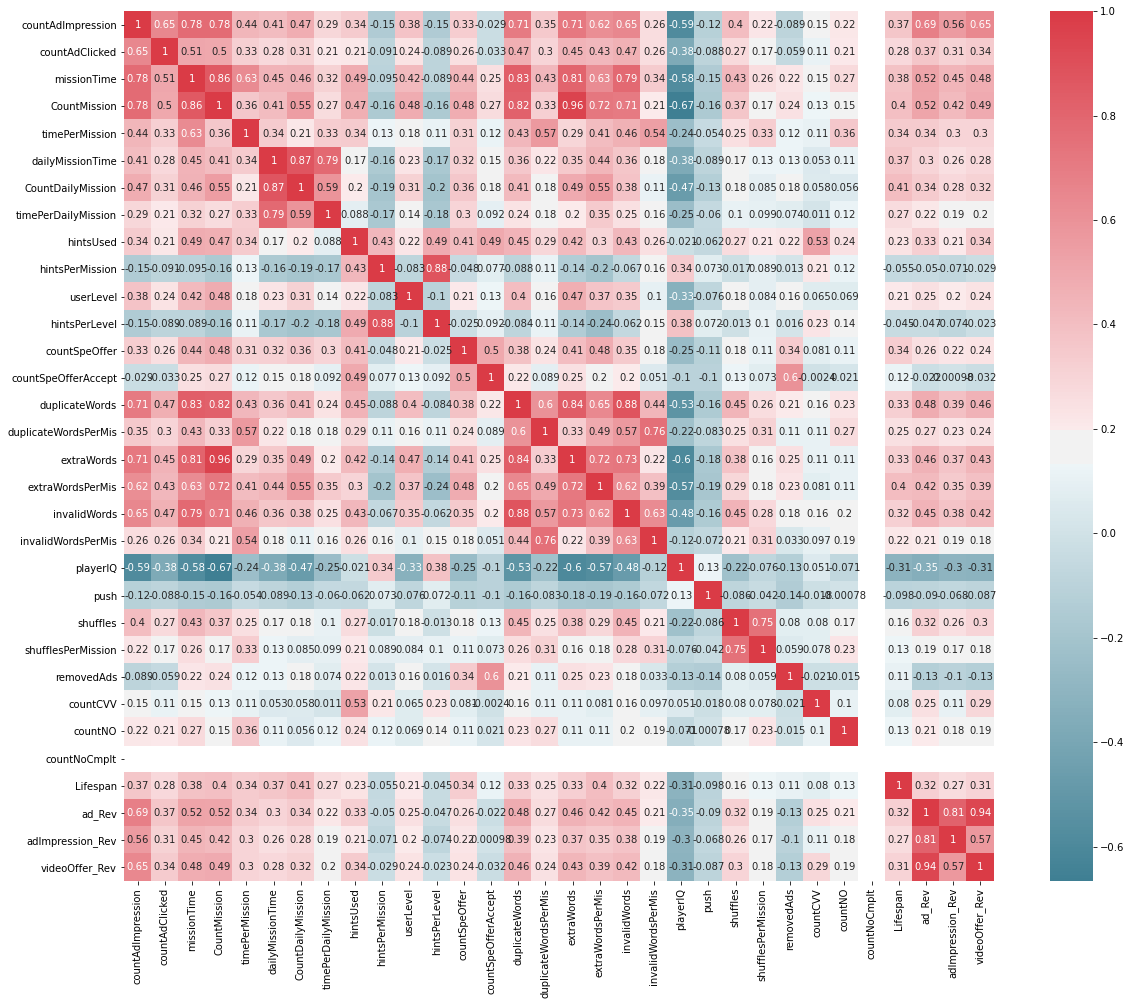

In [15]:
var_heatmap = var.drop(columns = ['gaUserAcquisitionChannel', 'platform'])
f, ax = plt.subplots(figsize=(20, 16))
corr = var_heatmap.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax,annot=True)

In [16]:
kmeans_var = var.drop(columns = ['gaUserAcquisitionChannel', 'platform'])
removeAds_players = kmeans_var[kmeans_var['removedAds']==1]
#kmeans_var["Ad_Impression_Value"] = 4*(kmeans_var['countAdImpression'] - kmeans_var['countAdClicked']) + 10*kmeans_var['countAdClicked']
kmeans_var = kmeans_var.drop(columns = ['countAdImpression', 'countAdClicked','timePerMission','timePerDailyMission','hintsPerMission',
                                        'timePerDailyMission','hintsPerLevel','duplicateWordsPerMis','extraWordsPerMis','invalidWordsPerMis',
                                      'shufflesPerMission','removedAds', 'countCVV', 'countNO', 'countNoCmplt', 'ad_Rev', 'adImpression_Rev', 'videoOffer_Rev'])

In [17]:
kmeans_var = kmeans_var[kmeans_var.userLevel != 0]
kmeans_var.to_csv('kmeans_var.csv')
kmeans_var_array = kmeans_var.to_numpy()
scaler = MinMaxScaler()
kmeans_var_array = scaler.fit_transform(kmeans_var_array)

In [18]:
kmeans_var_array

array([[1.47839777e-01, 1.03739445e-01, 0.00000000e+00, ...,
        1.00000000e+00, 1.91975427e-04, 1.00000000e+00],
       [3.00362308e-01, 1.00000000e+00, 3.97702165e-02, ...,
        1.00000000e+00, 1.42061816e-02, 1.00000000e+00],
       [1.65470748e-01, 5.91073583e-02, 2.65134777e-01, ...,
        1.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       ...,
       [8.06362086e-03, 2.17129071e-02, 0.00000000e+00, ...,
        1.00000000e+00, 1.91975427e-04, 0.00000000e+00],
       [5.86353407e-03, 8.44390832e-03, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 6.66666667e-01],
       [4.03685650e-05, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 3.33333333e-01]])

In [19]:
kmeans_var.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3577 entries, 9f951230-bf3e-408e-acfe-c91273015dd7 to fb01077c-001f-4a57-9d9e-edbdc0577b53
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   missionTime          3577 non-null   float64
 1   CountMission         3577 non-null   float64
 2   dailyMissionTime     3577 non-null   float64
 3   CountDailyMission    3577 non-null   float64
 4   hintsUsed            3577 non-null   float64
 5   userLevel            3577 non-null   float64
 6   countSpeOffer        3577 non-null   float64
 7   countSpeOfferAccept  3577 non-null   float64
 8   duplicateWords       3577 non-null   float64
 9   extraWords           3577 non-null   float64
 10  invalidWords         3577 non-null   float64
 11  playerIQ             3577 non-null   float64
 12  push                 3577 non-null   float64
 13  shuffles             3577 non-null   float64
 14  Lifespan             3577 

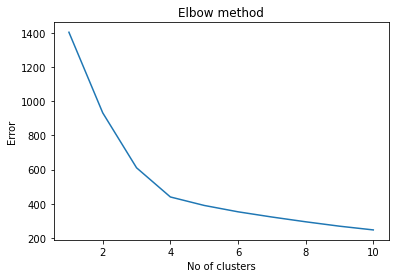

In [20]:
Error =[]
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i).fit(kmeans_var_array)
    kmeans.fit(kmeans_var_array)
    Error.append(kmeans.inertia_)

    
fig = plt.figure()
plt.plot(range(1, 11), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()
fig.savefig("ElbowCurve.jpg")

In [21]:
# build k-means clustering model with 4 clusters
kmeans4 = KMeans(n_clusters=4,random_state=40)
y_kmeans4 = kmeans4.fit_predict(kmeans_var_array)
print(y_kmeans4)

kmeans4.cluster_centers_

[3 1 3 ... 0 3 0]


array([[1.98585630e-02, 3.20819778e-02, 5.13153874e-02, 7.27272727e-02,
        2.72249770e-02, 5.46313097e-03, 8.13482418e-02, 1.50859242e-03,
        1.64751246e-02, 1.20535984e-02, 1.79497123e-02, 3.25210143e-01,
        1.00000000e+00, 2.09745053e-03, 1.83960820e-01],
       [1.16784240e-01, 1.22697156e-01, 3.95727744e-01, 5.64057971e-01,
        6.78956522e-02, 2.19533513e-02, 1.58567775e-01, 1.78053830e-02,
        9.39283771e-02, 8.22986089e-02, 9.42330205e-02, 1.67335563e-01,
        1.00000000e+00, 1.34374452e-02, 9.42028986e-01],
       [9.06476850e-02, 9.74720096e-02, 1.84166370e-01, 2.86396181e-01,
        5.69546539e-02, 1.62544226e-02, 1.43900042e-01, 1.87521309e-02,
        7.94404577e-02, 6.83098009e-02, 8.31238311e-02, 2.24710850e-01,
        1.88737914e-15, 1.35047153e-02, 7.66905330e-01],
       [4.97468208e-02, 5.58506846e-02, 6.42822054e-02, 9.22407542e-02,
        4.51167513e-02, 9.77498219e-03, 1.18926759e-01, 4.04019476e-03,
        3.82822625e-02, 2.69001789e-0

In [22]:
for i in range(0,len(kmeans_var.columns)):
    for n in range(0,4):
        print(kmeans_var.columns[i], ", cluster: ", n)
        print("Center: ", kmeans4.cluster_centers_[n][i])
        print('----------------------------------------')

missionTime , cluster:  0
Center:  0.01985856304237671
----------------------------------------
missionTime , cluster:  1
Center:  0.11678424011222463
----------------------------------------
missionTime , cluster:  2
Center:  0.0906476849627553
----------------------------------------
missionTime , cluster:  3
Center:  0.04974682081633012
----------------------------------------
CountMission , cluster:  0
Center:  0.032081977799709956
----------------------------------------
CountMission , cluster:  1
Center:  0.12269715564413212
----------------------------------------
CountMission , cluster:  2
Center:  0.09747200958108655
----------------------------------------
CountMission , cluster:  3
Center:  0.05585068461875576
----------------------------------------
dailyMissionTime , cluster:  0
Center:  0.05131538743397439
----------------------------------------
dailyMissionTime , cluster:  1
Center:  0.3957277437286669
----------------------------------------
dailyMissionTime , cluster:

In [23]:
for i in range(0,len(kmeans_var.columns)):
    print(str(kmeans_var.columns[i]) + ' ' +str(kmeans4.cluster_centers_[1][i]))

missionTime 0.11678424011222463
CountMission 0.12269715564413212
dailyMissionTime 0.3957277437286669
CountDailyMission 0.5640579710144933
hintsUsed 0.06789565217391308
userLevel 0.02195335127075799
countSpeOffer 0.1585677749360616
countSpeOfferAccept 0.01780538302277445
duplicateWords 0.09392837710837412
extraWords 0.08229860890722518
invalidWords 0.09423302047606333
playerIQ 0.16733556298773683
push 1.0000000000000016
shuffles 0.013437445224402588
Lifespan 0.942028985507247


In [24]:
kmeans_var.columns

Index(['missionTime', 'CountMission', 'dailyMissionTime', 'CountDailyMission',
       'hintsUsed', 'userLevel', 'countSpeOffer', 'countSpeOfferAccept',
       'duplicateWords', 'extraWords', 'invalidWords', 'playerIQ', 'push',
       'shuffles', 'Lifespan'],
      dtype='object')

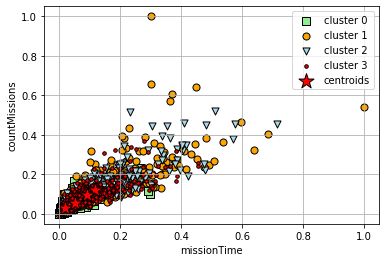

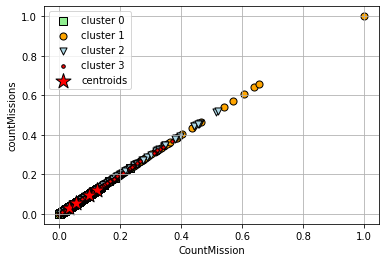

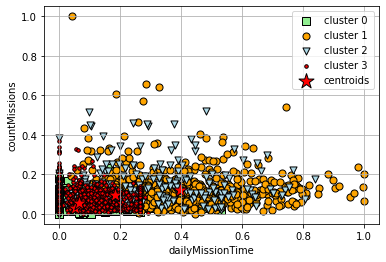

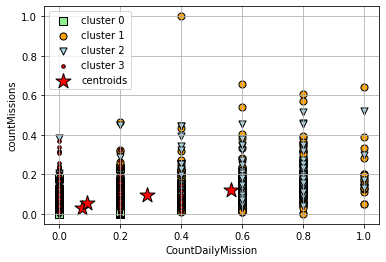

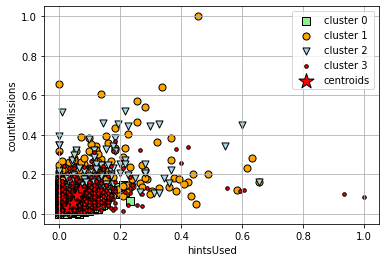

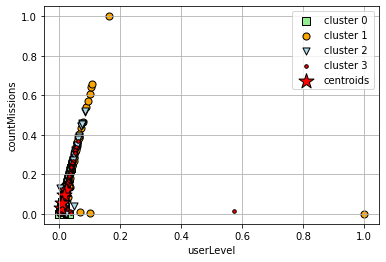

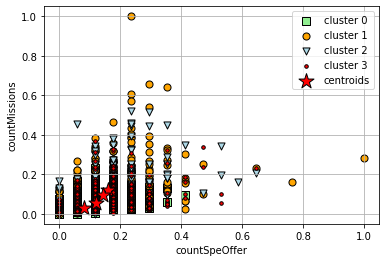

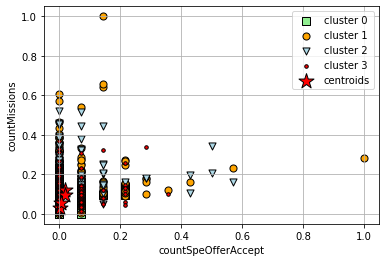

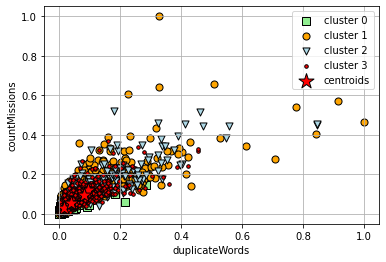

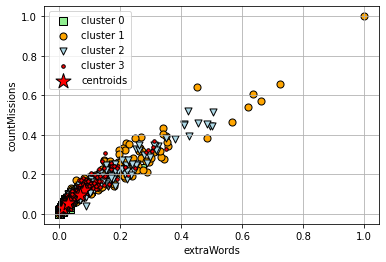

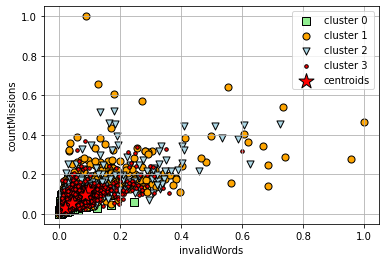

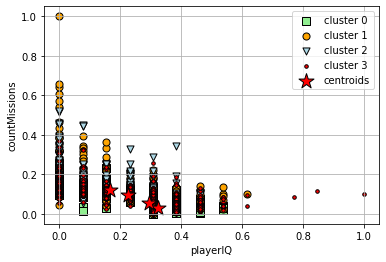

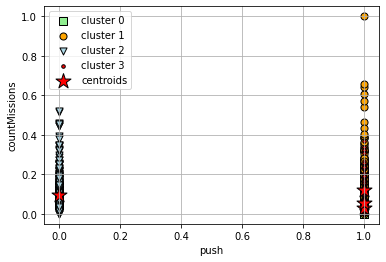

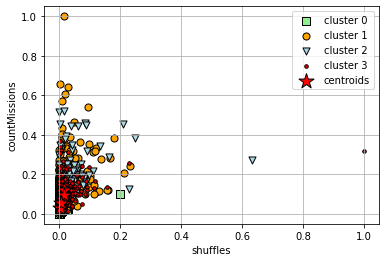

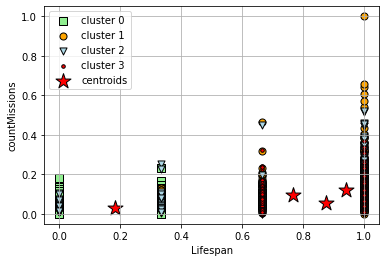

In [25]:
# plot the 4 clusters
for i in range(0,len(kmeans_var.columns)):
    plt.scatter(
        kmeans_var_array[y_kmeans4 == 0, i], kmeans_var_array[y_kmeans4 == 0, 1],
        s=50, c='lightgreen',
        marker='s', edgecolor='black',
        label='cluster 0'
    )

    plt.scatter(
        kmeans_var_array[y_kmeans4 == 1, i], kmeans_var_array[y_kmeans4 == 1, 1],
        s=50, c='orange',
        marker='o', edgecolor='black',
        label='cluster 1'
    )

    plt.scatter(
        kmeans_var_array[y_kmeans4 == 2, i], kmeans_var_array[y_kmeans4 == 2, 1],
        s=50, c='lightblue',
        marker='v', edgecolor='black',
        label='cluster 2'
    )

    plt.scatter(
        kmeans_var_array[y_kmeans4 == 3, i], kmeans_var_array[y_kmeans4 == 3, 1],
        s=50, c='red',
        marker='.', edgecolor='black',
        label='cluster 3'
    )

#    plot the centroids
    plt.scatter(
        kmeans4.cluster_centers_[:, i], kmeans4.cluster_centers_[:, 1],
        s=250, marker='*',
        c='red', edgecolor='black',
        label='centroids'
    )
    plt.legend(scatterpoints=1)
    plt.xlabel(kmeans_var.columns[i])
    plt.ylabel("countMissions")
    plt.grid()
    plt.show()

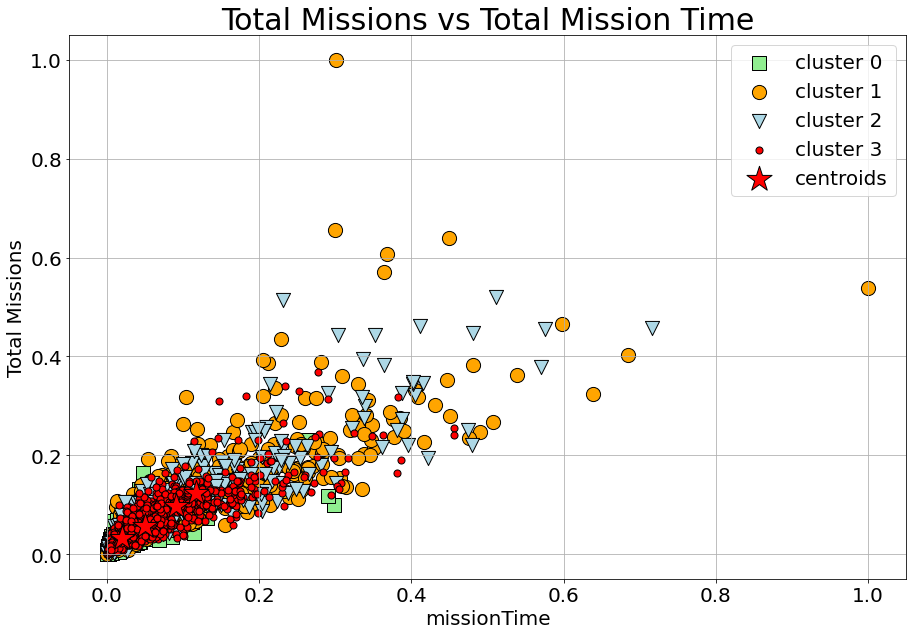

In [26]:
# for i in range(0,len(kmeans_var.columns)):
fig = plt.figure(figsize=(15, 10))
plt.scatter(
    kmeans_var_array[y_kmeans4 == 0, 0], kmeans_var_array[y_kmeans4 == 0, 1],
    s=200, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 0'
)

plt.scatter(
    kmeans_var_array[y_kmeans4 == 1, 0], kmeans_var_array[y_kmeans4 == 1, 1],
    s=200, c='orange',
    marker='o', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    kmeans_var_array[y_kmeans4 == 2, 0], kmeans_var_array[y_kmeans4 == 2, 1],
    s=200, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    kmeans_var_array[y_kmeans4 == 3, 0], kmeans_var_array[y_kmeans4 == 3, 1],
    s=200, c='red',
    marker='.', edgecolor='black',
    label='cluster 3'
)

#    plot the centroids
plt.scatter(
    kmeans4.cluster_centers_[:, 0], kmeans4.cluster_centers_[:, 1],
    s=700, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1,fontsize=20)
plt.xlabel(kmeans_var.columns[0],fontsize=20)
plt.ylabel("Total Missions",fontsize=20)
plt.title("Total Missions vs Total Mission Time", fontsize=30)
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20)
plt.grid()
plt.show()
fig.savefig("CountMissions_MissionTime.jpg")

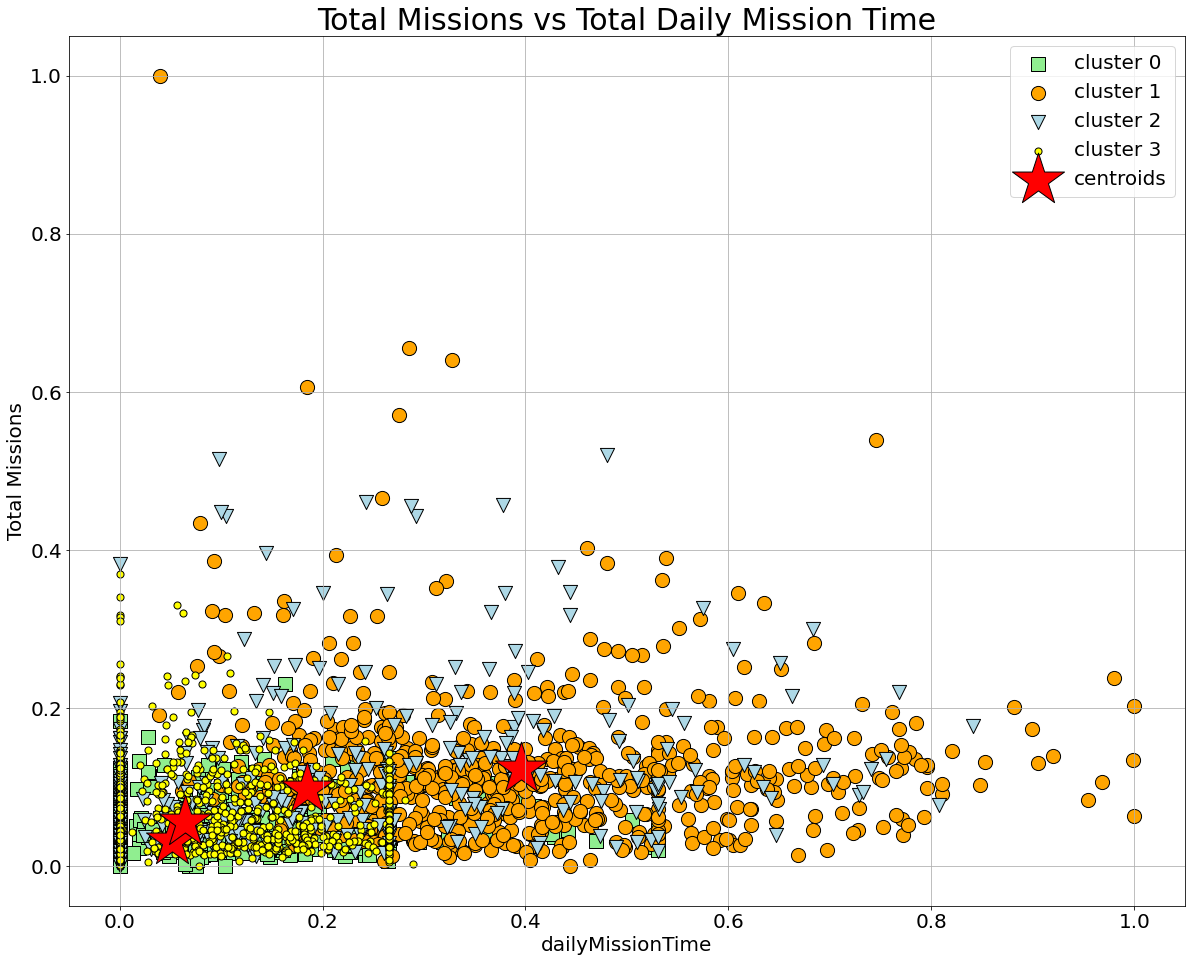

In [34]:
fig = plt.figure(figsize=(20, 16))
plt.scatter(
    kmeans_var_array[y_kmeans4 == 0, 2], kmeans_var_array[y_kmeans4 == 0, 1],
    s=200, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 0'
)

plt.scatter(
    kmeans_var_array[y_kmeans4 == 1, 2], kmeans_var_array[y_kmeans4 == 1, 1],
    s=200, c='orange',
    marker='o', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    kmeans_var_array[y_kmeans4 == 2, 2], kmeans_var_array[y_kmeans4 == 2, 1],
    s=200, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    kmeans_var_array[y_kmeans4 == 3, 2], kmeans_var_array[y_kmeans4 == 3, 1],
    s=200, c='yellow',
    marker='.', edgecolor='black',
    label='cluster 3'
)

#    plot the centroids
plt.scatter(
    kmeans4.cluster_centers_[:, 2], kmeans4.cluster_centers_[:, 1],
    s=3000, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)

    
plt.legend(scatterpoints=1,fontsize=20)
plt.xlabel(kmeans_var.columns[2],fontsize=20)
plt.ylabel("Total Missions",fontsize=20)
plt.title("Total Missions vs Total Daily Mission Time", fontsize=30)
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20)
plt.grid()
plt.show()
fig.savefig("CountMissions_DailyMissionTime.jpg")

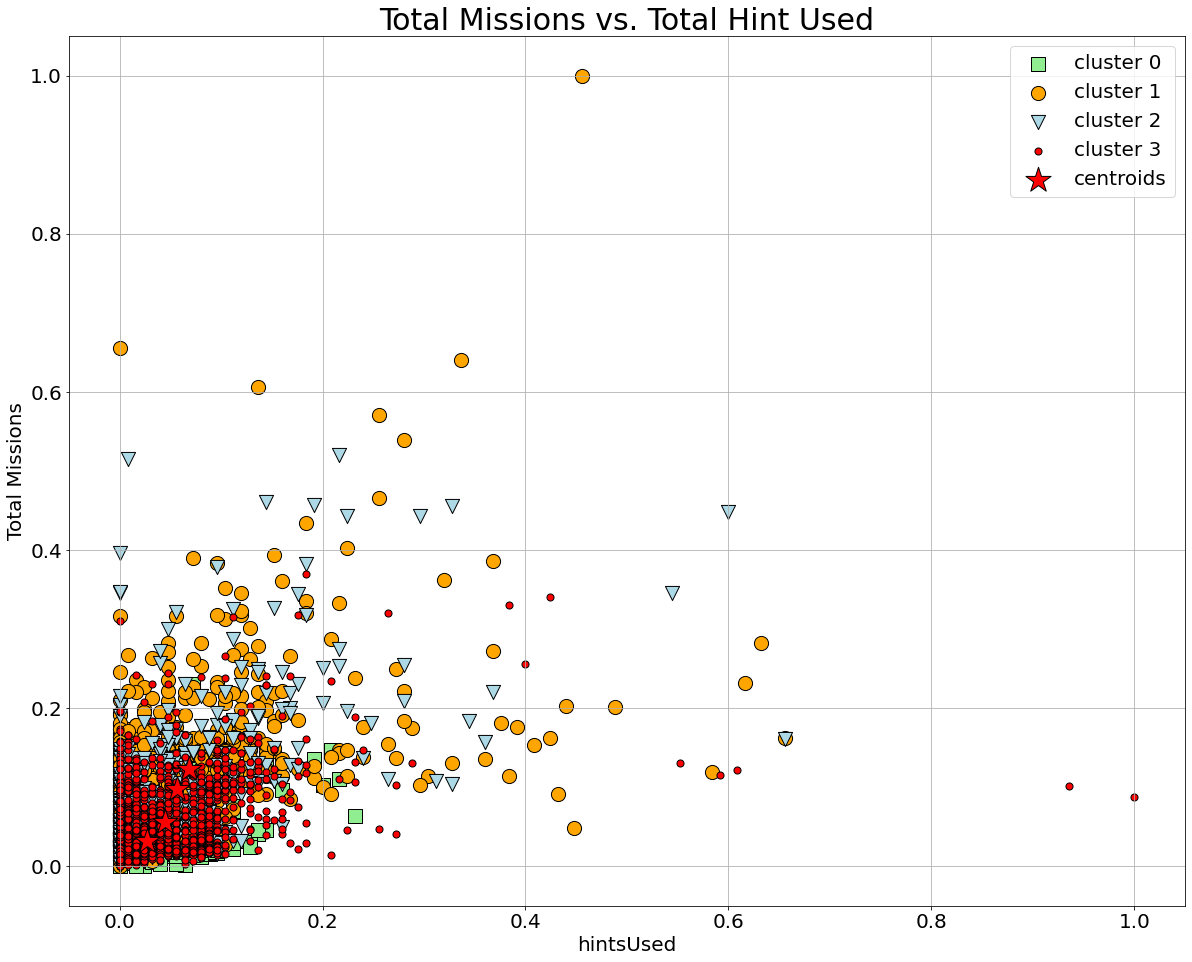

In [28]:
fig = plt.figure(figsize=(20, 16))
plt.scatter(
    kmeans_var_array[y_kmeans4 == 0, 4], kmeans_var_array[y_kmeans4 == 0, 1],
    s=200, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 0'
)

plt.scatter(
    kmeans_var_array[y_kmeans4 == 1, 4], kmeans_var_array[y_kmeans4 == 1, 1],
    s=200, c='orange',
    marker='o', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    kmeans_var_array[y_kmeans4 == 2, 4], kmeans_var_array[y_kmeans4 == 2, 1],
    s=200, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    kmeans_var_array[y_kmeans4 == 3, 4], kmeans_var_array[y_kmeans4 == 3, 1],
    s=200, c='red',
    marker='.', edgecolor='black',
    label='cluster 3'
)

#    plot the centroids
plt.scatter(
    kmeans4.cluster_centers_[:, 4], kmeans4.cluster_centers_[:, 1],
    s=700, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1,fontsize=20)
plt.xlabel(kmeans_var.columns[4],fontsize=20)
plt.ylabel("Total Missions",fontsize=20)
plt.title("Total Missions vs. Total Hint Used", fontsize=30)
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20)
plt.grid()
plt.show()
fig.savefig("CountMissions_TotalHint.jpg")

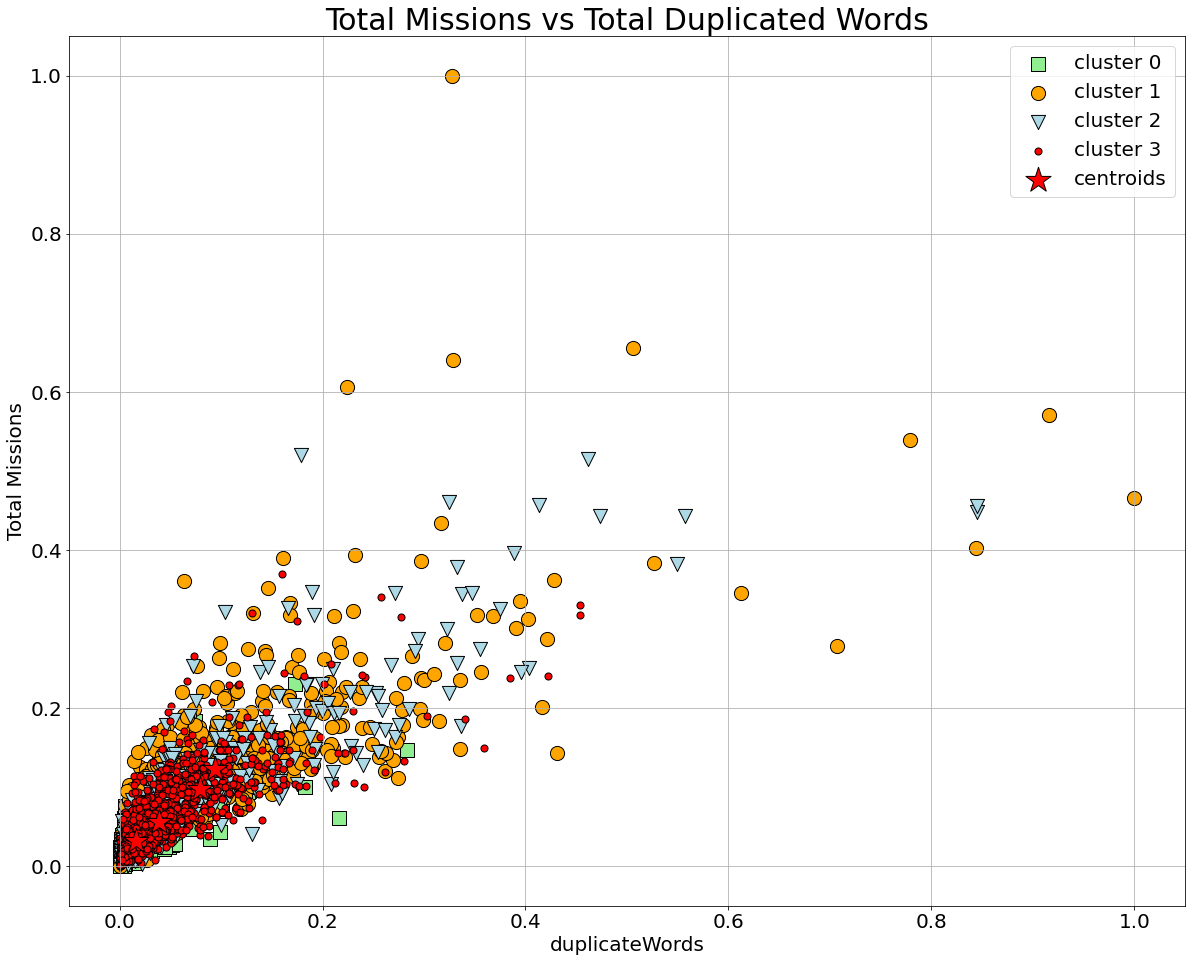

In [29]:
fig = plt.figure(figsize=(20, 16))
plt.scatter(
    kmeans_var_array[y_kmeans4 == 0, 8], kmeans_var_array[y_kmeans4 == 0, 1],
    s=200, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 0'
)

plt.scatter(
    kmeans_var_array[y_kmeans4 == 1, 8], kmeans_var_array[y_kmeans4 == 1, 1],
    s=200, c='orange',
    marker='o', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    kmeans_var_array[y_kmeans4 == 2, 8], kmeans_var_array[y_kmeans4 == 2, 1],
    s=200, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    kmeans_var_array[y_kmeans4 == 3, 8], kmeans_var_array[y_kmeans4 == 3, 1],
    s=200, c='red',
    marker='.', edgecolor='black',
    label='cluster 3'
)

#    plot the centroids
plt.scatter(
    kmeans4.cluster_centers_[:, 8], kmeans4.cluster_centers_[:, 1],
    s=700, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1,fontsize=20)
plt.xlabel(kmeans_var.columns[8],fontsize=20)
plt.ylabel("Total Missions",fontsize=20)
plt.title("Total Missions vs Total Duplicated Words", fontsize=30)
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20)
plt.grid()
plt.show()

In [36]:
kmeans_var['cluster'] = y_kmeans4

In [37]:
np.shape(kmeans_var[(kmeans_var['cluster'] == 0)])

(1089, 16)

In [38]:
np.shape(kmeans_var[(kmeans_var['cluster'] == 1)])

(690, 16)

In [39]:
np.shape(kmeans_var[(kmeans_var['cluster'] == 2)])

(419, 16)

In [40]:
np.shape(kmeans_var[(kmeans_var['cluster'] == 3)])

(1379, 16)

In [41]:
kmeans_var.head(2)

missionTime  CountMission  \
userID                                                            
9f951230-bf3e-408e-acfe-c91273015dd7      14652.0          87.0   
1FF0ECB5-5B5F-4677-BB9C-2CFE8039C4AA      29765.0         830.0   

                                      dailyMissionTime  CountDailyMission  \
userID                                                                      
9f951230-bf3e-408e-acfe-c91273015dd7               0.0                0.0   
1FF0ECB5-5B5F-4677-BB9C-2CFE8039C4AA              90.0                2.0   

                                      hintsUsed  userLevel  countSpeOffer  \
userID                                                                      
9f951230-bf3e-408e-acfe-c91273015dd7       12.0       87.0            3.0   
1FF0ECB5-5B5F-4677-BB9C-2CFE8039C4AA       57.0      830.0            4.0   

                                      countSpeOfferAccept  duplicateWords  \
userID                                                                      
9f951230-bf3e-408e-acfe-c91273015dd7                  0.0           303.0   
1FF0ECB5-5B5F-4677-BB9C-2CFE8039C4AA                  2.0           575.0   

                                      extraWords  invalidWords  playerIQ  \
userID                                                                     
9f951230-bf3e-408e-acfe-c91273015dd7       124.0        2640.0      -2.0   
1FF0ECB5-5B5F-4677-BB9C-2CFE8039C4AA      2192.0         732.0      -4.0   

                                      push  shuffles  Lifespan  cluster  
userID                                                                   
9f951230-bf3e-408e-acfe-c91273015dd7   1.0       1.0       3.0        3  
1FF0ECB5-5B5F-4677-BB9C-2CFE8039C4AA   1.0      74.0       3.0        1

In [42]:
removeAds_cluster = kmeans_var.loc[kmeans_var.index.intersection(set(removeAds_players.index))]
removeAds_cluster.head(2)



missionTime  CountMission  \
1FF0ECB5-5B5F-4677-BB9C-2CFE8039C4AA      29765.0         830.0   
3da50a81-dacb-4d47-abf6-5cfe2b390572       2762.0          49.0   

                                      dailyMissionTime  CountDailyMission  \
1FF0ECB5-5B5F-4677-BB9C-2CFE8039C4AA              90.0                2.0   
3da50a81-dacb-4d47-abf6-5cfe2b390572              57.0                1.0   

                                      hintsUsed  userLevel  countSpeOffer  \
1FF0ECB5-5B5F-4677-BB9C-2CFE8039C4AA       57.0      830.0            4.0   
3da50a81-dacb-4d47-abf6-5cfe2b390572       19.0       49.0            6.0   

                                      countSpeOfferAccept  duplicateWords  \
1FF0ECB5-5B5F-4677-BB9C-2CFE8039C4AA                  2.0           575.0   
3da50a81-dacb-4d47-abf6-5cfe2b390572                  3.0            60.0   

                                      extraWords  invalidWords  playerIQ  \
1FF0ECB5-5B5F-4677-BB9C-2CFE8039C4AA      2192.0         732.0      -4.0   
3da50a81-dacb-4d47-abf6-5cfe2b390572        67.0         106.0       2.0   

                                      push  shuffles  Lifespan  cluster  
1FF0ECB5-5B5F-4677-BB9C-2CFE8039C4AA   1.0      74.0       3.0        1  
3da50a81-dacb-4d47-abf6-5cfe2b390572   1.0       1.0       3.0        3

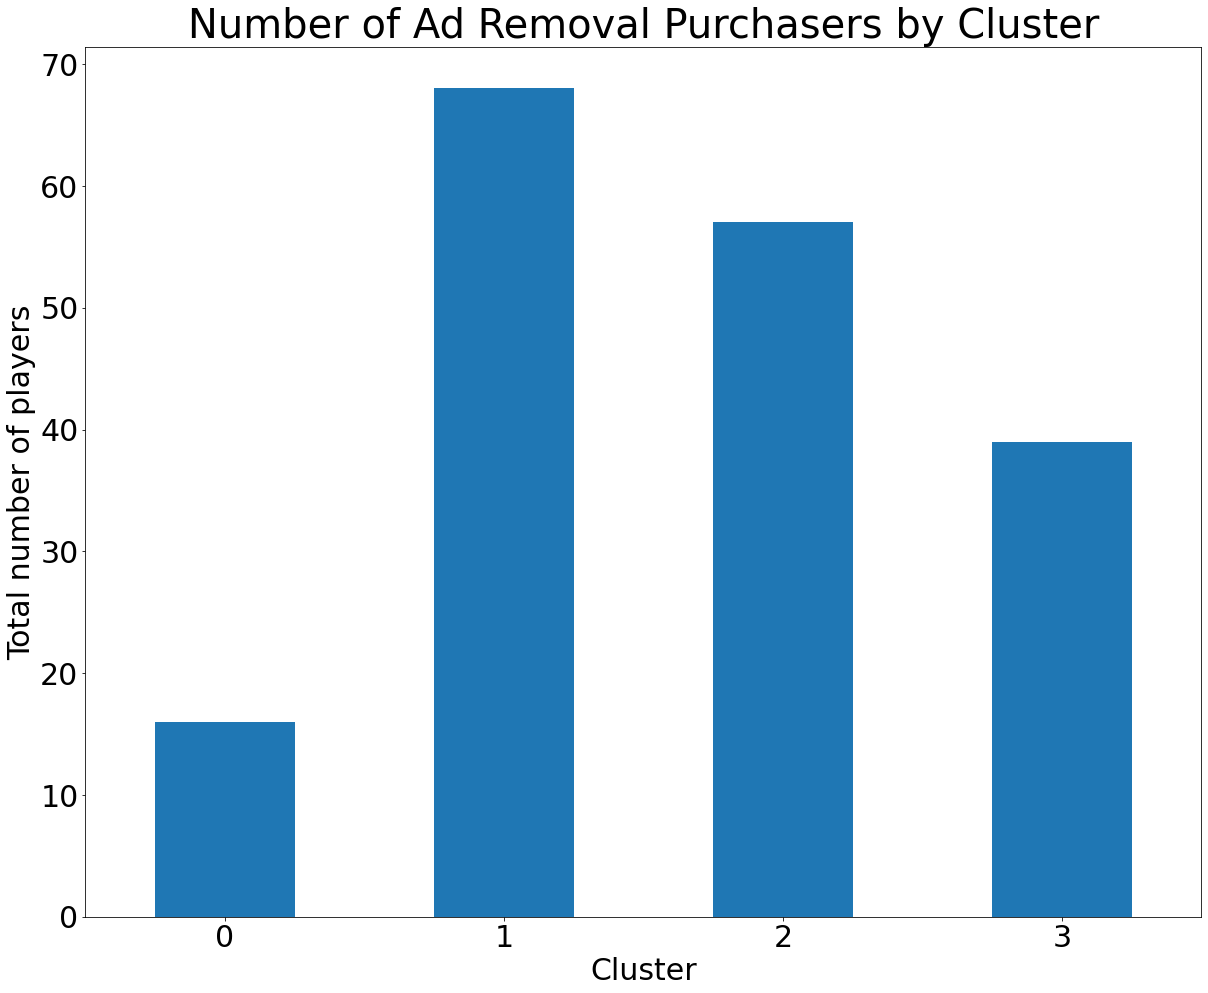

In [49]:
fig = plt.figure(figsize=(20, 16))
removeAds_cluster['cluster'].value_counts().sort_index().plot(kind = 'bar');
plt.xlabel("Cluster", fontsize=30)
plt.ylabel("Total number of players", fontsize=30)
plt.title("Number of Ad Removal Purchasers by Cluster", fontsize=40)
plt.xticks(fontsize=30, rotation=0)
plt.yticks(fontsize=30)
fig.savefig("Num_players_bar.jpg")

In [50]:
cluster0 = var.loc[kmeans_var[(kmeans_var['cluster'] == 0)].index,:]
cluster1 = var.loc[kmeans_var[(kmeans_var['cluster'] == 1)].index,:]
cluster2 = var.loc[kmeans_var[(kmeans_var['cluster'] == 2)].index,:]
cluster3 = var.loc[kmeans_var[(kmeans_var['cluster'] == 3)].index,:]

<Figure size 432x288 with 0 Axes>

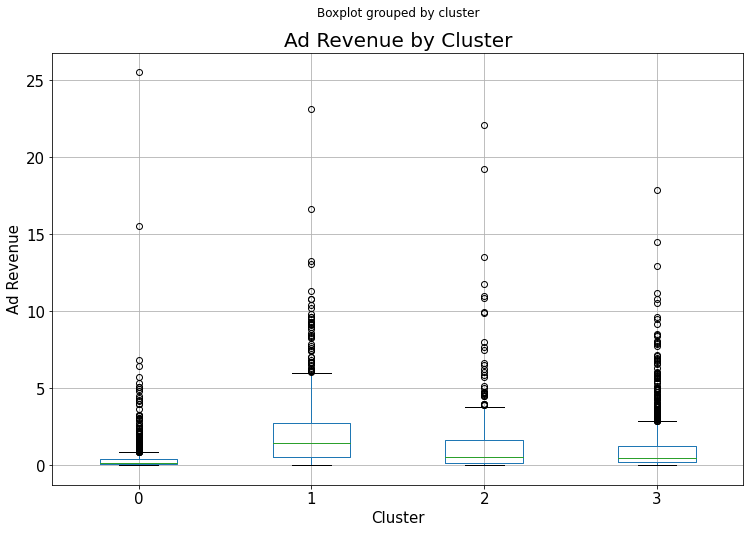

In [51]:

Day20_adRev=total_result[30][['userID','ad_Rev']]
kmeans_var['userID']=kmeans_var.index
cluster_info=kmeans_var[['userID','cluster']]
cluster_revenue=pd.merge(kmeans_var['cluster'],Day20_adRev, on='userID',how='left')

fig = plt.figure()
cluster_revenue.boxplot(by ='cluster', column =['ad_Rev'], figsize=(12,8)) 
plt.xlabel("Cluster", fontsize=15)
plt.ylabel("Ad Revenue", fontsize=15)
plt.title("Ad Revenue by Cluster", fontsize=20)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15)
fig.savefig("AdRev_boxplot.jpg")

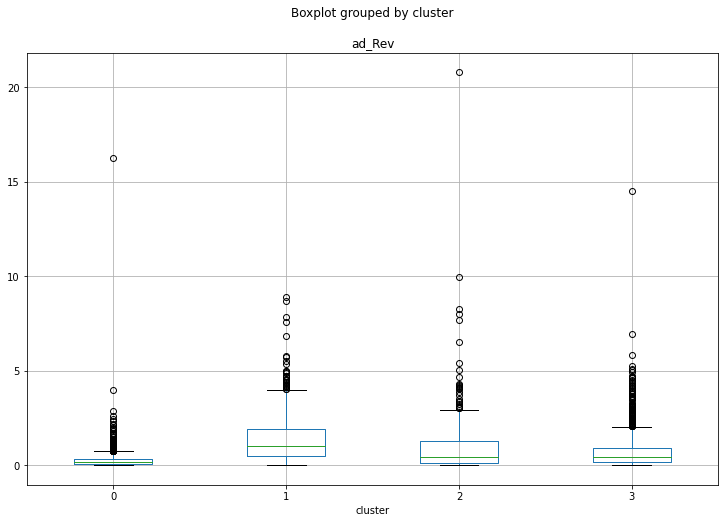

In [43]:
Day20_adRev=total_result[7][['userID','ad_Rev']]
kmeans_var['userID']=kmeans_var.index
cluster_info=kmeans_var[['userID','cluster']]
cluster_revenue=pd.merge(kmeans_var['cluster'],Day20_adRev, on='userID',how='left')
cluster_revenue.boxplot(by ='cluster', column =['ad_Rev'],  figsize=(12,8)) 

In [45]:
desired_indices0 = [i for i in cluster0.index if i not in removeAds_players.index]
cluster0.loc[desired_indices0,:][['Lifespan','userLevel','CountMission','ad_Rev', 'adImpression_Rev', 'videoOffer_Rev','dailyMissionTime']].describe()

Lifespan    userLevel  CountMission       ad_Rev  adImpression_Rev  \
count  1073.00000  1073.000000   1073.000000  1073.000000       1073.000000   
mean      0.54986    28.544268     27.403541     0.200979          0.053944   
std       0.49774    22.935994     22.391743     0.274745          0.087614   
min       0.00000     1.000000      1.000000     0.000327          0.000000   
25%       0.00000    14.000000     14.000000     0.041900          0.006050   
50%       1.00000    21.000000     20.000000     0.116590          0.024040   
75%       1.00000    35.000000     33.000000     0.252100          0.063010   
max       1.00000   192.000000    192.000000     3.983215          0.811602   

       videoOffer_Rev  dailyMissionTime  
count     1073.000000       1073.000000  
mean         0.147035        115.717614  
std          0.207693        211.590956  
min          0.000000          0.000000  
25%          0.031900          0.000000  
50%          0.080120          0.000000  
75%          0.191090        174.000000  
max          3.282880       1200.000000

In [47]:
desired_indices1 = [i for i in cluster1.index if i not in removeAds_players.index]
cluster1.loc[desired_indices1,:][['Lifespan','userLevel','CountMission','ad_Rev', 'adImpression_Rev', 'videoOffer_Rev','dailyMissionTime']].describe()

Lifespan    userLevel  CountMission      ad_Rev  adImpression_Rev  \
count  622.000000   622.000000    622.000000  622.000000        622.000000   
mean     2.821543   107.906752     98.049839    0.994106          0.309080   
std      0.415465   209.003165     61.859243    0.802836          0.314725   
min      1.000000    12.000000      1.000000    0.003240          0.000000   
25%      3.000000    60.250000     58.000000    0.441004          0.111391   
50%      3.000000    89.000000     87.000000    0.774632          0.221687   
75%      3.000000   123.000000    120.000000    1.326167          0.386504   
max      3.000000  5075.000000    504.000000    6.377161          3.947264   

       videoOffer_Rev  dailyMissionTime  
count      622.000000        622.000000  
mean         0.685025        899.721865  
std          0.603956        415.640167  
min          0.000000         87.000000  
25%          0.291196        586.000000  
50%          0.516735        835.500000  
75%          0.900375       1164.000000  
max          5.873060       2263.000000

In [47]:
desired_indices2 = [i for i in cluster2.index if i not in removeAds_players.index]
cluster2.loc[desired_indices2,:][['userLevel','CountMission','ad_Rev', 'adImpression_Rev', 'videoOffer_Rev','dailyMissionTime']].describe()

userLevel  CountMission      ad_Rev  adImpression_Rev  videoOffer_Rev  \
count  362.000000    362.000000  362.000000        362.000000      362.000000   
mean    76.425414     74.348066    0.785533          0.242775        0.542757   
std     69.886701     69.195058    1.285355          0.347222        1.011868   
min      2.000000      2.000000    0.000408          0.000000        0.000000   
25%     26.250000     26.000000    0.161082          0.041862        0.117960   
50%     59.000000     56.500000    0.433411          0.120081        0.295300   
75%    100.750000     95.500000    0.981144          0.295803        0.672509   
max    432.000000    432.000000   17.120498          3.388033       13.732465   

       dailyMissionTime  
count        362.000000  
mean         399.795580  
std          436.182339  
min            0.000000  
25%            0.000000  
50%          262.500000  
75%          632.250000  
max         1828.000000

In [48]:
desired_indices3 = [i for i in cluster3.index if i not in removeAds_players.index]
cluster3.loc[desired_indices3,:][['userLevel','CountMission','ad_Rev', 'adImpression_Rev', 'videoOffer_Rev','dailyMissionTime']].describe()

userLevel  CountMission       ad_Rev  adImpression_Rev  \
count  1340.000000   1340.000000  1340.000000       1340.000000   
mean     47.347761     46.258209     0.491111          0.159343   
std      38.828494     38.558576     0.661232          0.368518   
min       1.000000      1.000000     0.000526          0.000000   
25%      20.000000     19.000000     0.134740          0.030096   
50%      34.000000     34.000000     0.306085          0.079741   
75%      64.000000     63.000000     0.635299          0.189443   
max     307.000000    307.000000    14.495971         11.338744   

       videoOffer_Rev  dailyMissionTime  
count     1340.000000       1340.000000  
mean         0.331768        143.451493  
std          0.396444        202.061799  
min          0.000000          0.000000  
25%          0.090287          0.000000  
50%          0.209526          0.000000  
75%          0.438013        269.000000  
max          4.447284        655.000000

## Summarize each cluster using data from day 0 to day 7

In [52]:
day7 = total_result[30]
day7.set_index('userID', inplace = True)
day7.dropna(axis=0, how='all', thresh=None, subset=None, inplace=True)

day7 = day7.dropna(subset = ['gaUserAcquisitionChannel', 'platform'])
day7.fillna(0 , inplace = True)

In [53]:
day7.head(2)

countAdImpression  countAdClicked  \
userID                                                                    
9f951230-bf3e-408e-acfe-c91273015dd7               60.0             4.0   
1FF0ECB5-5B5F-4677-BB9C-2CFE8039C4AA                1.0             0.0   

                                      missionTime  CountMission  \
userID                                                            
9f951230-bf3e-408e-acfe-c91273015dd7      15644.0          89.0   
1FF0ECB5-5B5F-4677-BB9C-2CFE8039C4AA      94356.0        2238.0   

                                      timePerMission  dailyMissionTime  \
userID                                                                   
9f951230-bf3e-408e-acfe-c91273015dd7      175.775281               0.0   
1FF0ECB5-5B5F-4677-BB9C-2CFE8039C4AA       42.160858             283.0   

                                      CountDailyMission  timePerDailyMission  \
userID                                                                         
9f951230-bf3e-408e-acfe-c91273015dd7                0.0                  0.0   
1FF0ECB5-5B5F-4677-BB9C-2CFE8039C4AA                5.0                 56.6   

                                      hintsUsed  hintsPerMission  ...  \
userID                                                            ...   
9f951230-bf3e-408e-acfe-c91273015dd7       12.0         0.134831  ...   
1FF0ECB5-5B5F-4677-BB9C-2CFE8039C4AA      147.0         0.065684  ...   

                                        gaUserAcquisitionChannel  platform  \
userID                                                                       
9f951230-bf3e-408e-acfe-c91273015dd7  android af_cross_promotion   ANDROID   
1FF0ECB5-5B5F-4677-BB9C-2CFE8039C4AA               ios peoplefun       IOS   

                                      removedAds  countCVV  countNO  \
userID                                                                
9f951230-bf3e-408e-acfe-c91273015dd7         0.0       0.0      6.0   
1FF0ECB5-5B5F-4677-BB9C-2CFE8039C4AA         1.0       0.0      0.0   

                                      countNoCmplt  Lifespan    ad_Rev  \
userID                                                                   
9f951230-bf3e-408e-acfe-c91273015dd7           0.0         4  0.704107   
1FF0ECB5-5B5F-4677-BB9C-2CFE8039C4AA           0.0         7  0.000000   

                                      adImpression_Rev  videoOffer_Rev  
userID                                                                  
9f951230-bf3e-408e-acfe-c91273015dd7          0.175453        0.528654  
1FF0ECB5-5B5F-4677-BB9C-2CFE8039C4AA          0.000000        0.000000  

[2 rows x 34 columns]

In [54]:
day7_cluster0= day7.loc[cluster0.index,:]
day7_cluster1= day7.loc[cluster1.index,:]
day7_cluster2= day7.loc[cluster2.index,:]
day7_cluster3= day7.loc[cluster3.index,:]

In [55]:
day7_cluster0['ad_Rev'].describe()

count    1089.000000
mean        0.408301
std         1.139992
min         0.000000
25%         0.052800
50%         0.156590
75%         0.372070
max        25.508408
Name: ad_Rev, dtype: float64

In [56]:
day7_cluster1['ad_Rev'].describe()

count    690.000000
mean       2.105333
std        2.386703
min        0.000000
25%        0.546006
50%        1.414109
75%        2.743451
max       23.136602
Name: ad_Rev, dtype: float64

In [57]:
day7_cluster2['ad_Rev'].describe()

count    419.000000
mean       1.337921
std        2.283141
min        0.000000
25%        0.143660
50%        0.559900
75%        1.633791
max       22.066688
Name: ad_Rev, dtype: float64

In [58]:
day7_cluster3['ad_Rev'].describe()

count    1379.000000
mean        1.061710
std         1.584553
min         0.000000
25%         0.194818
50%         0.492620
75%         1.261782
max        17.904846
Name: ad_Rev, dtype: float64

## Lasso Regression within each cluster to predict total ads value

### Cluster 0

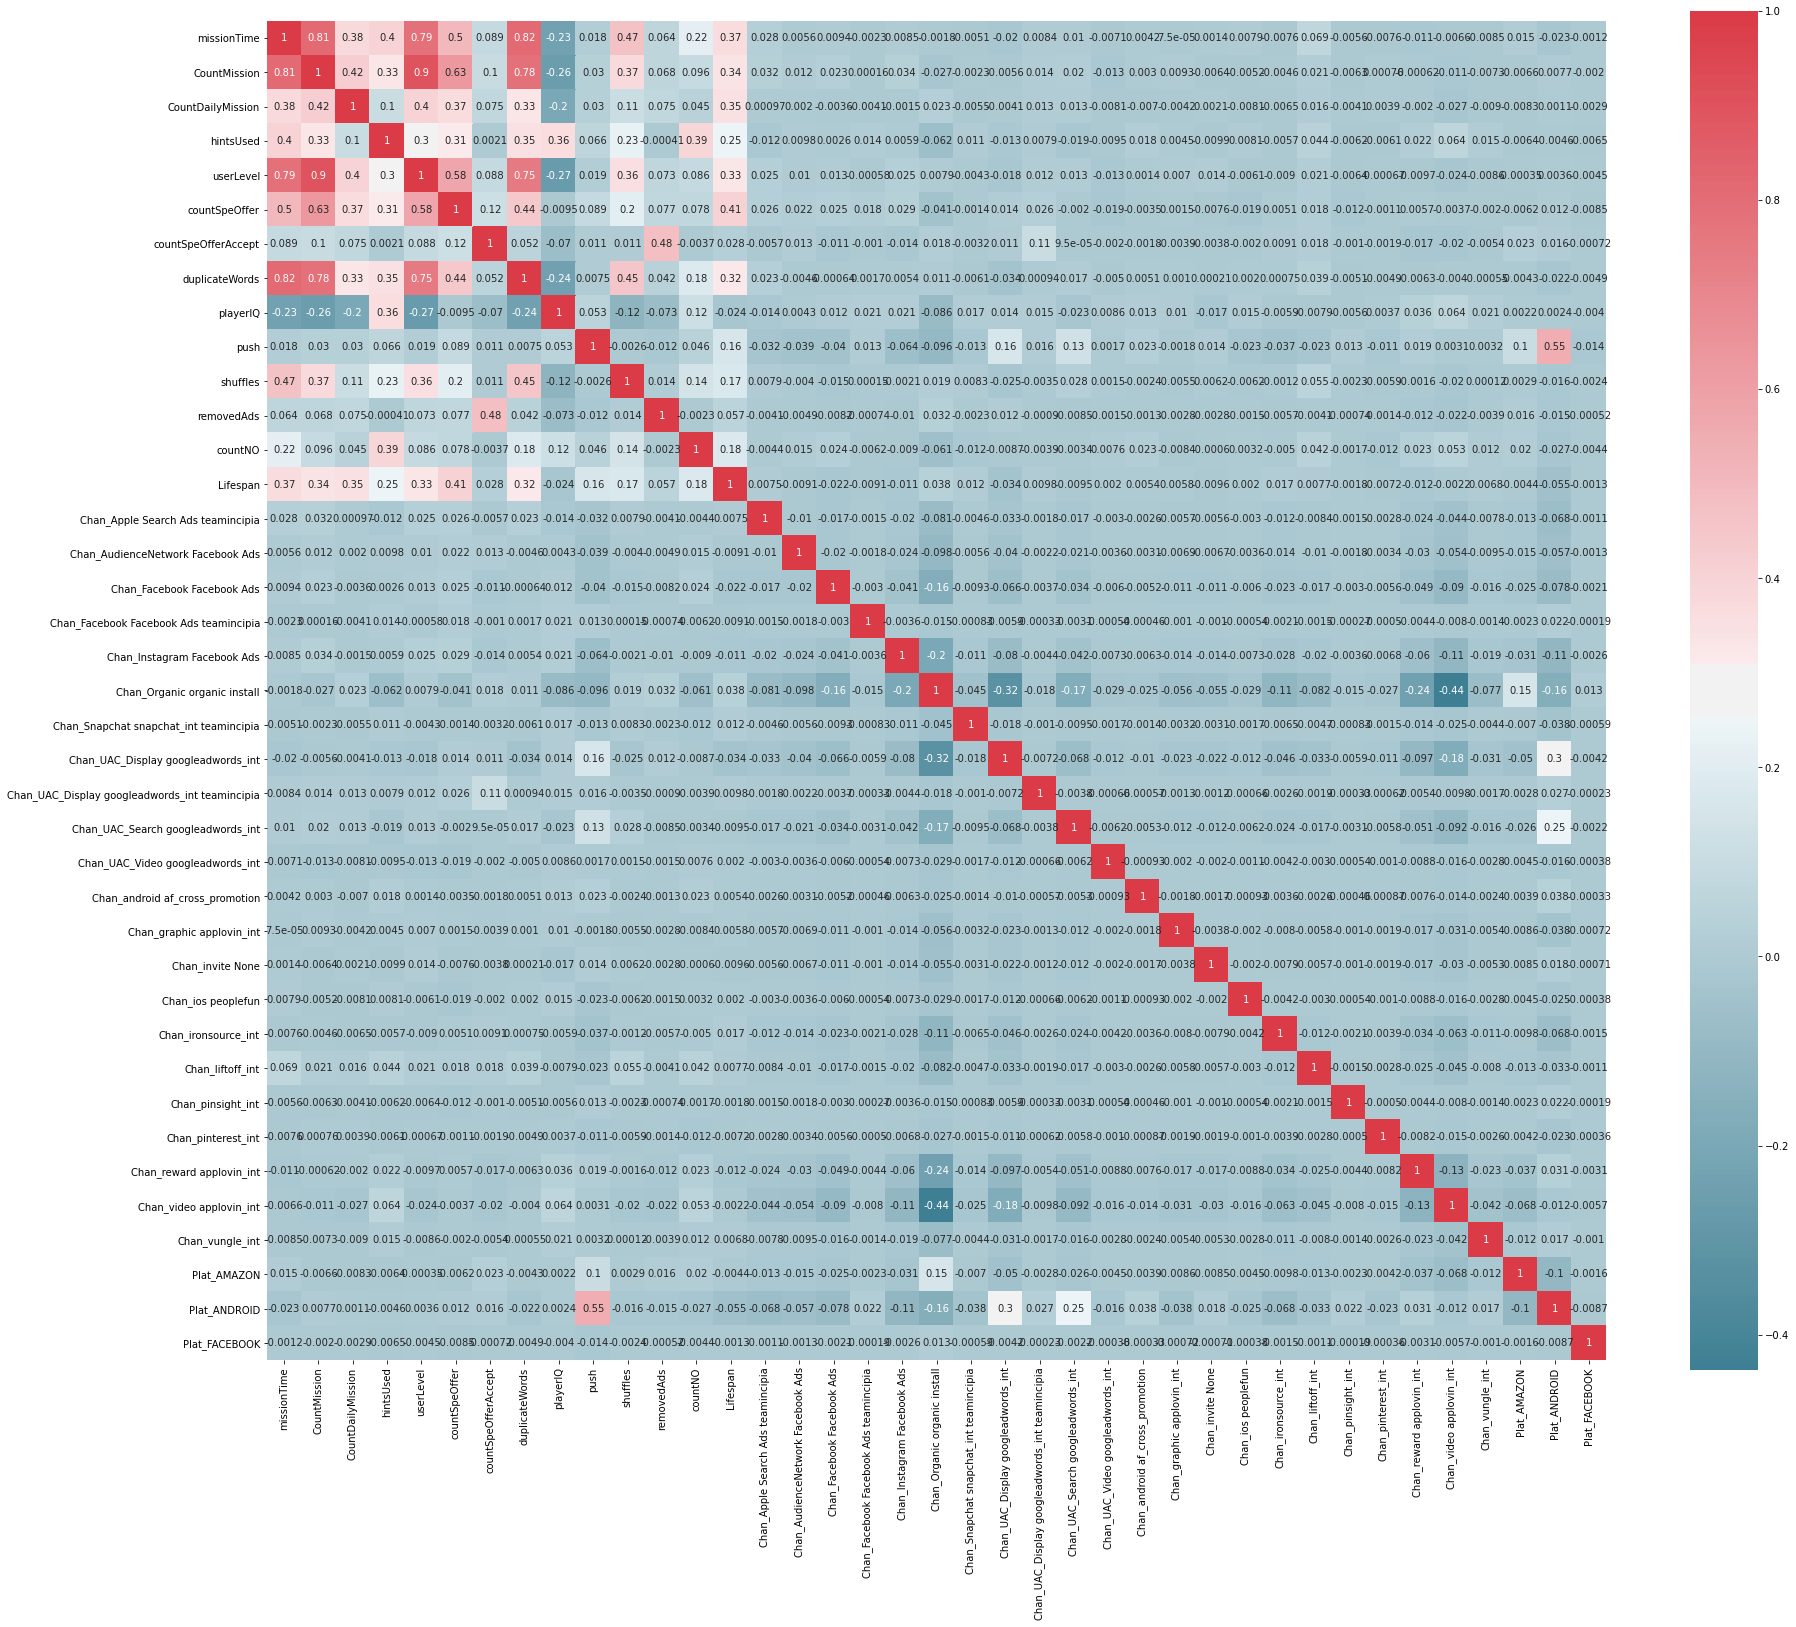

In [44]:
cols = ['countAdImpression','countAdClicked','timePerMission', 'timePerDailyMission', 'hintsPerMission','dailyMissionTime', 'hintsPerLevel','duplicateWordsPerMis','extraWordsPerMis', 'invalidWordsPerMis','shufflesPerMission','countCVV', 'countNoCmplt', 'ad_Rev', 'adImpression_Rev', 'videoOffer_Rev']

cls0_x = day7_cluster0.drop(columns=cols)
cls0_x = pd.get_dummies(cls0_x, columns = ['gaUserAcquisitionChannel','platform'], prefix=['Chan', 'Plat'], drop_first=False)
cls0_x = cls0_x.drop(columns='Plat_IOS')
cls0_x = cls0_x.drop(columns = ['extraWords', 'invalidWords'])

var_heatmap0 = cls0_x
f, ax = plt.subplots(figsize=(30, 25))
corr = var_heatmap0.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax,annot=True)

In [45]:
# LassoCV on cluster 0
cls0_x = preprocessing.normalize(cls0_x, norm='l2')
cls0_y = day7_cluster0['ad_Rev'] 

x0_train, x0_test, y0_train, y0_test = train_test_split(cls0_x, cls0_y, test_size=0.2, random_state=42)
reg_lcv = LassoCV(cv=5, random_state=0)
cls0_reg_lcv = reg_lcv.fit(x0_train, y0_train)

y0_test_predicted_lcv = cls0_reg_lcv.predict(x0_test)

print('R-square: ', cls0_reg_lcv.score(x0_test, y0_test))
print('MSE: ', mean_squared_error(y0_test,y0_test_predicted_lcv))
print('Coeffcients: ', cls0_reg_lcv.coef_)

R-square:  0.008347979153338625
MSE:  0.008599252838585134
Coeffcients:  [-0.28960226 -0.22475069  0.40470315 -0.24994666 -0.17903029  1.18729045
 -1.22637345 -0.02983212 -1.60342528 -0.1035402  -0.06507061 -0.
 -0.04276565 -0.07544222  0.05446121  0.13863112 -0.          0.
 -0.20900266  0.06324972  0.          0.06093011  0.          0.01706825
 -0.         -0.          0.08272362 -0.          0.         -0.
 -0.         -0.         -0.          0.00919946  0.01732092  0.
 -0.1512128   0.08293136 -0.        ]


In [46]:
alpha = np.arange(0.1, 1, 0.01)
parameters = {'alpha': alpha}

lml = linear_model.Lasso(normalize=False)

clf = GridSearchCV(lml, parameters)
print(clf.fit(x0_train, y0_train).best_params_['alpha'])
cls0_lml = linear_model.Lasso(alpha = clf.fit(x0_train, y0_train).best_params_['alpha']).fit(x0_train, y0_train)


y0_test_predicted_lml = clf.predict(x0_test)
print(cls0_lml.score(x0_test, y0_test))
print(mean_squared_error(y0_test,y0_test_predicted_lml))

0.1
-0.0013319963745745955
0.008683194135820398


### Cluster 1

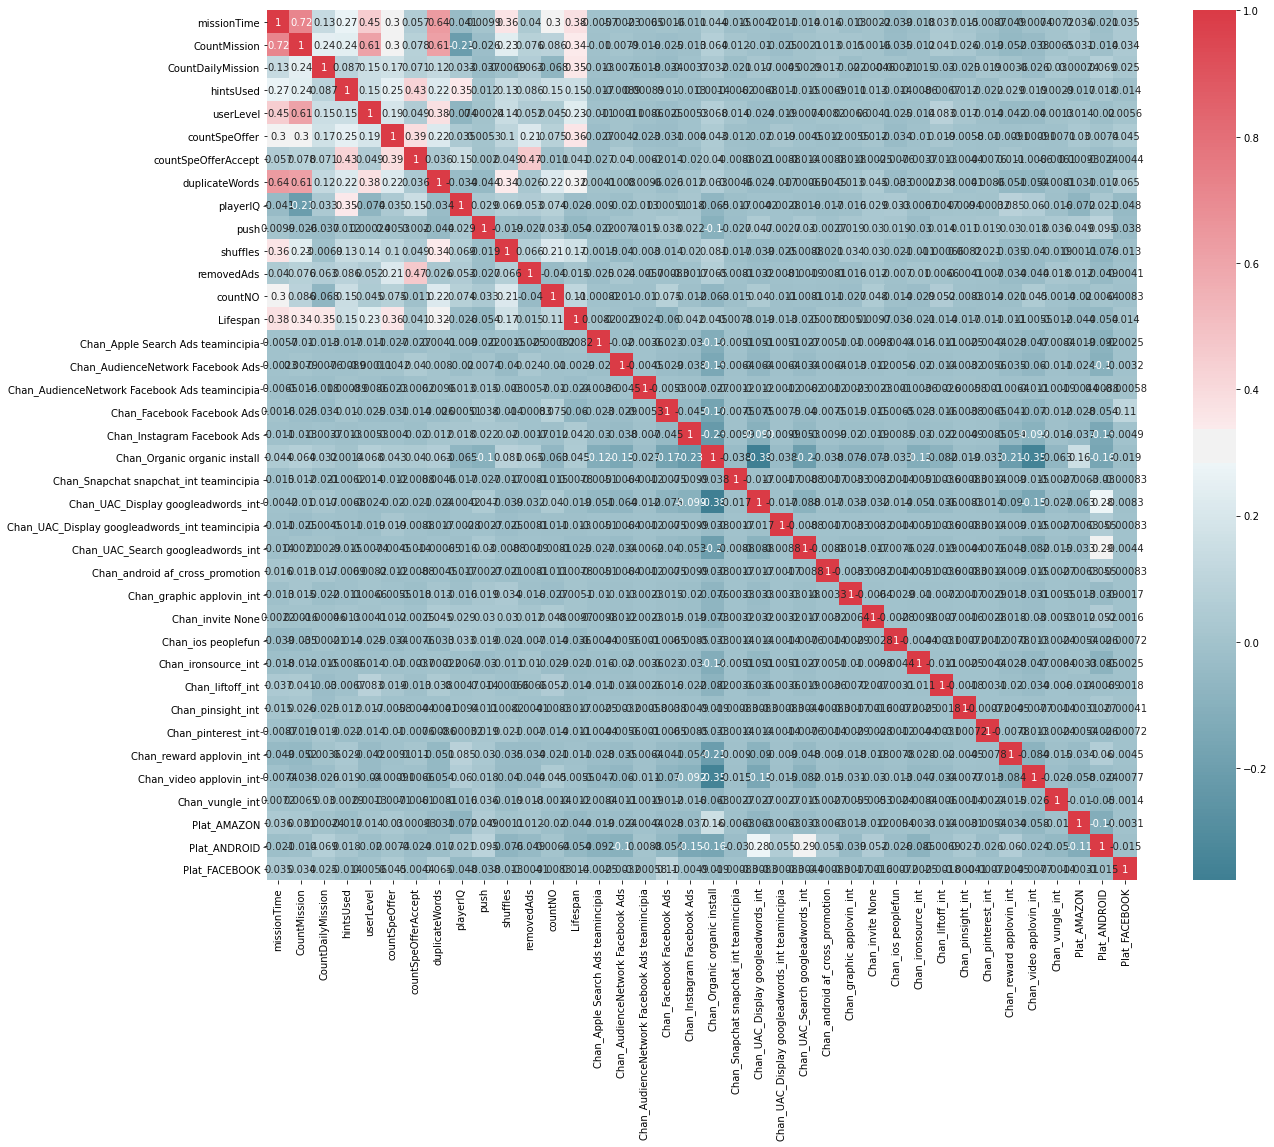

In [47]:
cls1_x = day7_cluster1.drop(columns=cols)
cls1_x = pd.get_dummies(cls1_x, columns = ['gaUserAcquisitionChannel','platform'], prefix=['Chan', 'Plat'], drop_first=False)
cls1_x = cls1_x.drop(columns = ['Plat_IOS','extraWords','invalidWords'])

var_heatmap1 = cls1_x
f, ax = plt.subplots(figsize=(20, 16))
corr = var_heatmap1.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax,annot=True)

In [48]:
# LassoCV on cluster 1
cls1_x = preprocessing.normalize(cls1_x, norm='l2')
cls1_y = day7_cluster1['ad_Rev'] 

x1_train, x1_test, y1_train, y1_test = train_test_split(cls1_x, cls1_y, test_size=0.2, random_state=42)

reg_lcv = LassoCV(cv=5, random_state=0)
cls1_reg_lcv = reg_lcv.fit(x1_train, y1_train)

y1_test_predicted_lcv = cls1_reg_lcv.predict(x1_test)

print('R-square:', cls1_reg_lcv.score(x1_test, y1_test))
print('MSE:', mean_squared_error(y1_test,y1_test_predicted_lcv))
print('Coeffcients: ', cls1_reg_lcv.coef_)

R-square: 0.10449128512560624
MSE: 1.1744828748712168
Coeffcients:  [-7.34682968e+00 -3.10272683e+01  0.00000000e+00  9.56056393e+01
 -4.66944079e+00 -0.00000000e+00 -0.00000000e+00  1.94780646e-01
  0.00000000e+00 -0.00000000e+00 -3.09451935e+00 -0.00000000e+00
 -0.00000000e+00 -1.46239453e+01 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  3.90881383e+03 -0.00000000e+00]


### Cluster 2

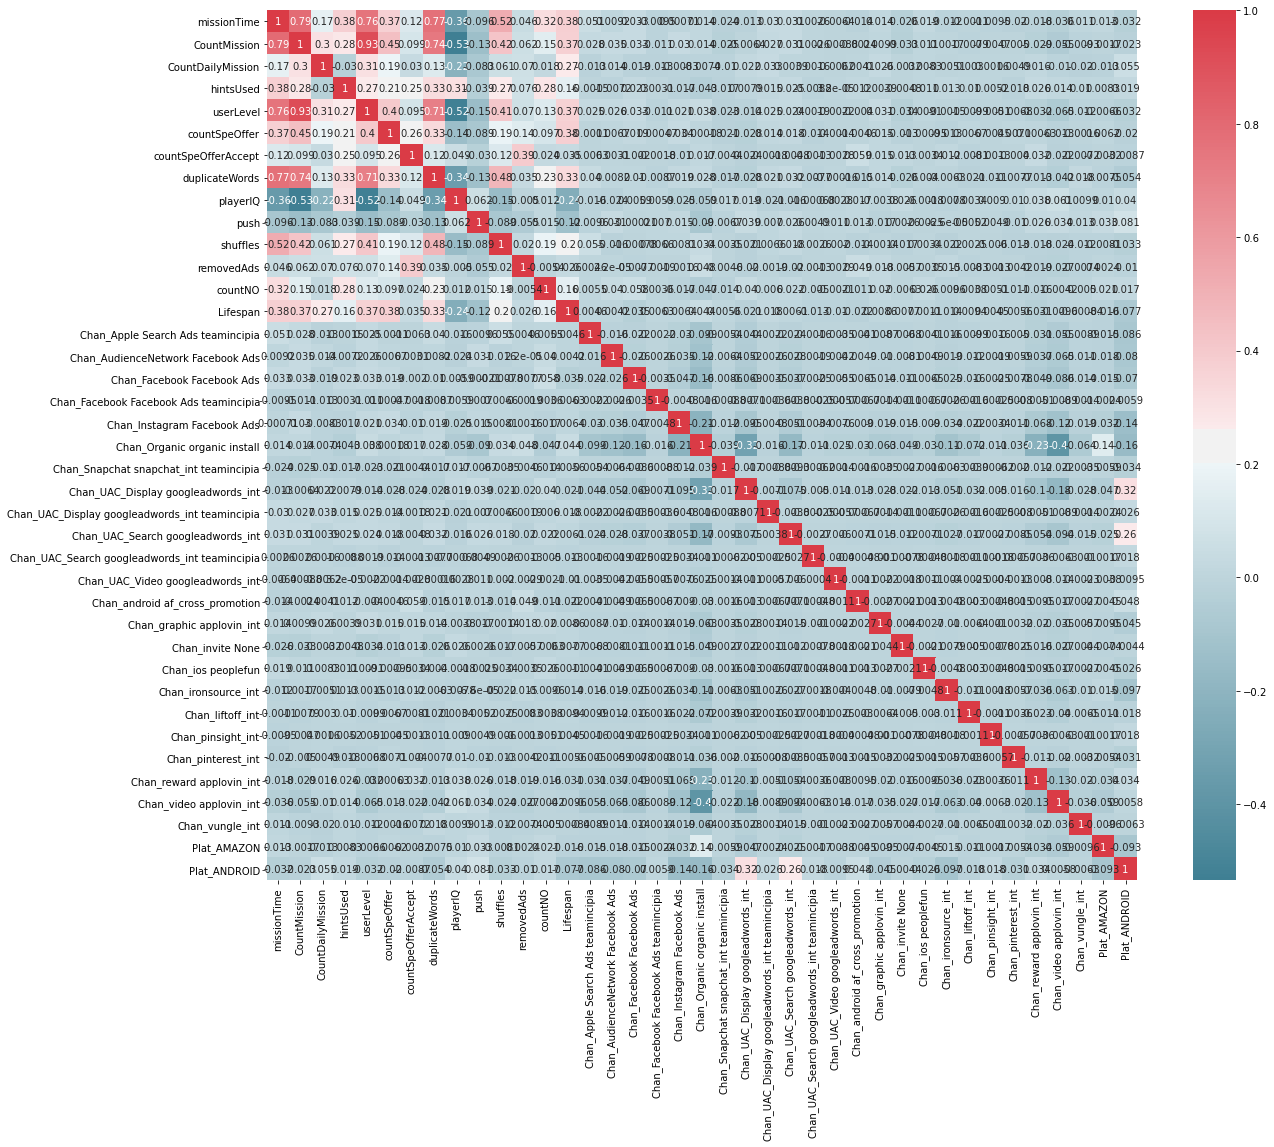

In [49]:
cls2_x = day7_cluster2.drop(columns=cols)
cls2_x = pd.get_dummies(cls2_x, columns = ['gaUserAcquisitionChannel','platform'], prefix=['Chan', 'Plat'], drop_first=False)
cls2_x = cls2_x.drop(columns = ['Plat_IOS','extraWords','invalidWords'])

var_heatmap2 = cls2_x
f, ax = plt.subplots(figsize=(20, 16))
corr = var_heatmap2.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)

In [50]:
# LassoCV on cluster 2
cls2_x = preprocessing.normalize(cls2_x, norm='l2')
cls2_y = day7_cluster2['ad_Rev'] 

x2_train, x2_test, y2_train, y2_test = train_test_split(cls2_x, cls2_y, test_size=0.2, random_state=42)

reg_lcv = LassoCV(cv=5, random_state=0)
cls2_reg_lcv = reg_lcv.fit(x2_train, y2_train)

y2_test_predicted_lcv = cls2_reg_lcv.predict(x2_test)

print('R-square:',cls2_reg_lcv.score(x2_test, y2_test))
print('MSE:',mean_squared_error(y2_test,y2_test_predicted_lcv))
print('Coeffcients: ', cls2_reg_lcv.coef_)

R-square: 0.015262299893234355
MSE: 0.19326424872578202
Coeffcients:  [ -1.6253641   -2.18152384   0.656596    -1.16757178  -1.46069802
  -0.           0.12476745  -1.64371633 -11.55711139  -4.22140475
   0.48767341   0.           0.93598568  -1.6949199   -0.
  -0.          -0.          -0.          -1.0103941    0.
  -0.           0.           0.           0.           0.
  -0.           0.          -0.          -0.          -0.
  -0.          -0.           0.          -0.          -0.
  -0.           0.          -0.          11.64725954]


### Cluster 3

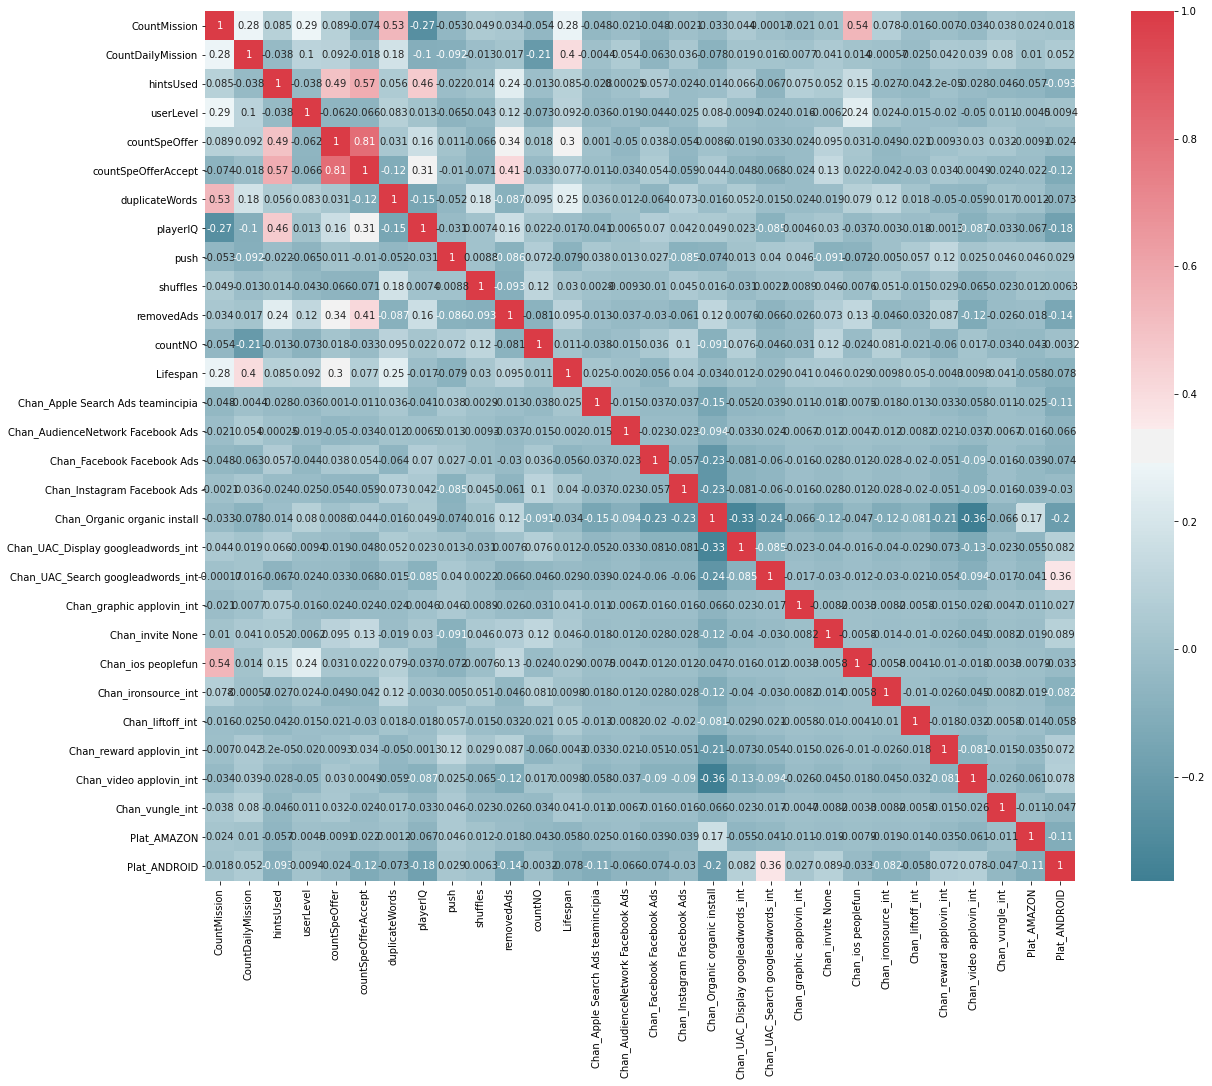

In [51]:
cls3_x = day7_cluster3.drop(columns=cols)
cls3_x = pd.get_dummies(cls3_x, columns = ['gaUserAcquisitionChannel','platform'], prefix=['Chan', 'Plat'], drop_first=False)
cls3_x = cls3_x.drop(columns = 'Plat_IOS')
cls3_x = cls3_x.drop(columns = ['extraWords','invalidWords','missionTime'])

var_heatmap3 = cls3_x
f, ax = plt.subplots(figsize=(20, 16))
corr = var_heatmap3.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)

In [52]:
# LassoCV on cluster 3
cls3_x = preprocessing.normalize(cls3_x, norm='l2')
cls3_y = day7_cluster3['ad_Rev'] 
x3_train, x3_test, y3_train, y3_test = train_test_split(cls3_x, cls3_y, test_size=0.2, random_state=42)

reg_lcv = LassoCV(cv=5, random_state=0)
cls3_reg_lcv = reg_lcv.fit(x3_train, y3_train)

y3_test_predicted_lcv = cls3_reg_lcv.predict(x3_test)

print('R-square',cls3_reg_lcv.score(x3_test, y3_test))
print('MSE:', mean_squared_error(y3_test,y3_test_predicted_lcv))
print('Coeffcients: ', cls3_reg_lcv.coef_)

R-square 0.3873854325369033
MSE: 1.1001479667545402
Coeffcients:  [ 7.24984714e-01 -1.46633166e+01 -1.38224691e+00 -7.30218774e-01
 -3.64099509e+01 -0.00000000e+00 -3.49943665e-02  7.54465774e+01
 -2.32791602e+01  6.65134532e-01  0.00000000e+00 -5.86725883e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  1.39581341e+03]


## KNN Regression to predict total ads revenue within each cluster

### Cluster 0

In [57]:
n = np.arange(1, 300, 1)
parameters = {'n_neighbors': n}

neigh = KNeighborsRegressor()

knn_cv = GridSearchCV(neigh, parameters)
print(knn_cv.fit(x0_train, y0_train).best_params_['n_neighbors'])
cls0_neigh = KNeighborsRegressor(n_neighbors = knn_cv.fit(x0_train, y0_train).best_params_['n_neighbors']).fit(x0_train, y0_train)

y0_test_predicted_knn = cls0_neigh.predict(x0_test)

print('R-square:',cls0_neigh.score(x0_test, y0_test))
print('MSE: ', mean_squared_error(y0_test,y0_test_predicted_knn))

238
R-square: 0.0066039334853766896
MSE:  0.008614376580931808


### Cluster 1

In [54]:
n = np.arange(1, 100, 1)
parameters = {'n_neighbors': n}

neigh = KNeighborsRegressor()

knn_cv = GridSearchCV(neigh, parameters)
print(knn_cv.fit(x1_train, y1_train).best_params_['n_neighbors'])
cls1_neigh = KNeighborsRegressor(n_neighbors = knn_cv.fit(x1_train, y1_train).best_params_['n_neighbors']).fit(x1_train, y1_train)

y1_test_predicted_knn = cls1_neigh.predict(x1_test)

print('R-square:',cls1_neigh.score(x1_test, y1_test))
print('MSE: ', mean_squared_error(y1_test,y1_test_predicted_knn))

92
R-square: 0.002865706024962722
MSE:  1.3077674541500655


### Cluster 2

In [55]:
n = np.arange(1, 100, 1)
parameters = {'n_neighbors': n}

neigh = KNeighborsRegressor()

knn_cv = GridSearchCV(neigh, parameters)
print(knn_cv.fit(x2_train, y2_train).best_params_['n_neighbors'])
cls2_neigh = KNeighborsRegressor(n_neighbors = knn_cv.fit(x2_train, y2_train).best_params_['n_neighbors']).fit(x2_train, y2_train)

y2_test_predicted_knn = cls2_neigh.predict(x2_test)

print('R-square:',cls2_neigh.score(x2_test, y2_test))
print('MSE: ', mean_squared_error(y2_test,y2_test_predicted_knn))

95
R-square: 0.0398555544315089
MSE:  0.18843758588800683


### Cluster 3

In [56]:
n = np.arange(1, 100, 1)
parameters = {'n_neighbors': n}

neigh = KNeighborsRegressor()

knn_cv = GridSearchCV(neigh, parameters)
print(knn_cv.fit(x3_train, y3_train).best_params_['n_neighbors'])
cls3_neigh = KNeighborsRegressor(n_neighbors = knn_cv.fit(x3_train, y3_train).best_params_['n_neighbors']).fit(x3_train, y3_train)

y3_test_predicted_knn = cls3_neigh.predict(x3_test)

print('R-square:',cls3_neigh.score(x3_test, y3_test))
print('MSE: ', mean_squared_error(y3_test,y3_test_predicted_knn))

86
R-square: -0.05882479775396132
MSE:  1.9014630246586128
